In [1]:
# import module
import random
import numpy as np
from itertools import count
from collections import deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import gym

# make game
env = gym.make('CartPole-v1')

# seed the experiment
env.seed(9)
np.random.seed(9)
random.seed(9) 
torch.manual_seed(9)

/Users/Kevin/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [2]:
# define our policy
class DQN(nn.Module):
    def __init__(self, observation_space, action_space):
        super(DQN, self).__init__()
        self.observation_space = observation_space
        self.action_space = action_space
        self.fc1 = nn.Linear(self.observation_space, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, self.action_space)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# define our agent
class Agent:
    def __init__(self, policy_net, target_net):
        MEMORY_SIZE = 10000
        GAMMA = 0.6
        BATCH_SIZE = 128
        EXPLORATION_MAX = 0.9
        EXPLORATION_MIN = 0.05
        EXPLORATION_DECAY = 0.95
        # 1, 2, 3 
        TARGET_UPDATE = 1

        self.policy_net = policy_net
        self.target_net = target_net
        self.target_net.load_state_dict(policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.RMSprop(policy_net.parameters(), lr=1e-3)
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.gamma = GAMMA
        self.batch_size = BATCH_SIZE
        self.exploration_rate = EXPLORATION_MAX
        self.exploration_min = EXPLORATION_MIN
        self.exploration_decay = EXPLORATION_DECAY
        self.target_update = TARGET_UPDATE
    
    def select_action(self, state):
        if np.random.rand() < self.exploration_rate:
            return torch.tensor([[random.randrange(self.policy_net.action_space)]])
        else:
            with torch.no_grad():
                q_values = self.policy_net(state)
            return q_values.max(1)[1].view(1,1)

    def remember(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))

    def update_target_net(self, i_episode):
        if i_episode % self.target_update == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

    def experience_replay(self):
        if len(self.memory) < self.batch_size:
            return
        # fetch data
        print("[ Experience replay ] starts")
        batch = random.sample(self.memory, self.batch_size)
        batch_state = torch.cat(tuple([x[0] for x in batch]))
        batch_action = torch.cat(tuple([x[1] for x in batch]))
        batch_reward = torch.cat(tuple([x[2] for x in batch]))
        batch_next_state = [x[3] for x in batch]
        non_final_next_states = torch.cat(tuple([s for s in batch_next_state if s is not None]))
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch_next_state)), dtype=torch.bool)
        
        # policy net forward pass to get Q values
        state_action_values = self.policy_net(batch_state).gather(1, batch_action)
        # target net forward pass to get Q values of next state
        next_state_values = torch.zeros(self.batch_size)
        next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()
        expected_state_action_values = (next_state_values * self.gamma).unsqueeze(1) + batch_reward

        # train policy
        policy_loss = F.smooth_l1_loss(state_action_values, expected_state_action_values)
        policy_loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

        # the more policy gets replayed, the less the agent explores
        self.exploration_rate *= self.exploration_decay
        self.exploration_rate = max(self.exploration_min, self.exploration_rate)

In [3]:
# create policy
observation_space = env.observation_space.shape[0]
action_space = env.action_space.n
policy_net = DQN(observation_space, action_space)
target_net = DQN(observation_space, action_space)

# create agent
agent = Agent(policy_net, target_net)

# play game
game_durations = []
for i_episode in count(1):
    state = env.reset()
    state = torch.tensor([state]).float()
    print("[ episode {} ] state={}".format(i_episode, state))
    for t in range(1, 10000):
        action = agent.select_action(state)
        state_next, reward, done, _ = env.step(action.item())
        if done:
            state_next = None
        else:
            state_next = torch.tensor([state_next]).float()
        agent.remember(state, action, torch.tensor([[reward]]).float(), state_next)
        print("[ episode {} ][ timestamp {} ] state={}, action={}, reward={}, next_state={}".format(i_episode, t, state, action, reward, state_next))
        state = state_next
        agent.experience_replay()
        if done:
            game_durations.append(t)
            break
    print("[ Ended! ] Episode {}: Exploration_rate={}. Score={}.".format(i_episode, agent.exploration_rate, t))
    # Update the target network, copying all weights and biases in DQN
    agent.update_target_net(i_episode)

    # end game criteria
    if t > env.spec.reward_threshold:
        print("[ Solved! ] Score is now {}".format(t))
        break
    elif i_episode > 500:
        print("[ Failed! ] took more than 500 episodes")
        break


[ episode 1 ] state=tensor([[-0.0055,  0.0210,  0.0088,  0.0255]])
[ episode 1 ][ timestamp 1 ] state=tensor([[-0.0055,  0.0210,  0.0088,  0.0255]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0051,  0.2160,  0.0094, -0.2644]])
[ episode 1 ][ timestamp 2 ] state=tensor([[-0.0051,  0.2160,  0.0094, -0.2644]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0008,  0.4110,  0.0041, -0.5541]])
[ episode 1 ][ timestamp 3 ] state=tensor([[-0.0008,  0.4110,  0.0041, -0.5541]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0074,  0.6061, -0.0070, -0.8455]])
[ episode 1 ][ timestamp 4 ] state=tensor([[ 0.0074,  0.6061, -0.0070, -0.8455]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0196,  0.4110, -0.0239, -0.5551]])
[ episode 1 ][ timestamp 5 ] state=tensor([[ 0.0196,  0.4110, -0.0239, -0.5551]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0278,  0.2163, -0.0350, -0.2700]])
[ episode 1 ][ timestamp 6 ] state=tensor([[ 0.0278,  0.21

[ episode 8 ][ timestamp 7 ] state=tensor([[ 0.0033,  0.0044, -0.0185,  0.0109]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0034, -0.1904, -0.0183,  0.2977]])
[ Experience replay ] starts
[ episode 8 ][ timestamp 8 ] state=tensor([[ 0.0034, -0.1904, -0.0183,  0.2977]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0004,  0.0049, -0.0123, -0.0007]])
[ Experience replay ] starts
[ episode 8 ][ timestamp 9 ] state=tensor([[-0.0004,  0.0049, -0.0123, -0.0007]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-2.7817e-04,  2.0024e-01, -1.2311e-02, -2.9721e-01]])
[ Experience replay ] starts
[ episode 8 ][ timestamp 10 ] state=tensor([[-2.7817e-04,  2.0024e-01, -1.2311e-02, -2.9721e-01]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0037,  0.0053, -0.0183, -0.0084]])
[ Experience replay ] starts
[ episode 8 ][ timestamp 11 ] state=tensor([[ 0.0037,  0.0053, -0.0183, -0.0084]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0038,  0.2

[ episode 11 ][ timestamp 4 ] state=tensor([[-0.0288,  0.5898,  0.0273, -0.8314]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0170,  0.7846,  0.0107, -1.1154]])
[ Experience replay ] starts
[ episode 11 ][ timestamp 5 ] state=tensor([[-0.0170,  0.7846,  0.0107, -1.1154]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.3122e-03,  9.7955e-01, -1.1601e-02, -1.4047e+00]])
[ Experience replay ] starts
[ episode 11 ][ timestamp 6 ] state=tensor([[-1.3122e-03,  9.7955e-01, -1.1601e-02, -1.4047e+00]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0183,  0.7846, -0.0397, -1.1157]])
[ Experience replay ] starts
[ episode 11 ][ timestamp 7 ] state=tensor([[ 0.0183,  0.7846, -0.0397, -1.1157]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0340,  0.9802, -0.0620, -1.4205]])
[ Experience replay ] starts
[ episode 11 ][ timestamp 8 ] state=tensor([[ 0.0340,  0.9802, -0.0620, -1.4205]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0536,  

[ episode 14 ][ timestamp 9 ] state=tensor([[ 0.0631,  0.7792, -0.1663, -1.3351]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0787,  0.9759, -0.1930, -1.6749]])
[ Experience replay ] starts
[ episode 14 ][ timestamp 10 ] state=tensor([[ 0.0787,  0.9759, -0.1930, -1.6749]]), action=tensor([[1]]), reward=1.0, next_state=None
[ Experience replay ] starts
[ Ended! ] Episode 14: Exploration_rate=0.05. Score=10.
[ episode 15 ] state=tensor([[ 0.0171, -0.0254,  0.0036,  0.0462]])
[ episode 15 ][ timestamp 1 ] state=tensor([[ 0.0171, -0.0254,  0.0036,  0.0462]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0166,  0.1696,  0.0045, -0.2454]])
[ Experience replay ] starts
[ episode 15 ][ timestamp 2 ] state=tensor([[ 0.0166,  0.1696,  0.0045, -0.2454]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0200, -0.0255, -0.0004,  0.0487]])
[ Experience replay ] starts
[ episode 15 ][ timestamp 3 ] state=tensor([[ 0.0200, -0.0255, -0.0004,  0.0487]]), action=tensor

[ episode 17 ][ timestamp 14 ] state=tensor([[ 0.1494,  0.6115, -0.1755, -1.1312]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1616,  0.4191, -0.1981, -0.8983]])
[ Experience replay ] starts
[ episode 17 ][ timestamp 15 ] state=tensor([[ 0.1616,  0.4191, -0.1981, -0.8983]]), action=tensor([[1]]), reward=1.0, next_state=None
[ Experience replay ] starts
[ Ended! ] Episode 17: Exploration_rate=0.05. Score=15.
[ episode 18 ] state=tensor([[-0.0382,  0.0317, -0.0049, -0.0367]])
[ episode 18 ][ timestamp 1 ] state=tensor([[-0.0382,  0.0317, -0.0049, -0.0367]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0375,  0.2269, -0.0057, -0.3309]])
[ Experience replay ] starts
[ episode 18 ][ timestamp 2 ] state=tensor([[-0.0375,  0.2269, -0.0057, -0.3309]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0330,  0.4221, -0.0123, -0.6254]])
[ Experience replay ] starts
[ episode 18 ][ timestamp 3 ] state=tensor([[-0.0330,  0.4221, -0.0123, -0.6254]]), action=tenso

[ Ended! ] Episode 21: Exploration_rate=0.05. Score=10.
[ episode 22 ] state=tensor([[-0.0198, -0.0091,  0.0434, -0.0008]])
[ episode 22 ][ timestamp 1 ] state=tensor([[-0.0198, -0.0091,  0.0434, -0.0008]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0200, -0.2049,  0.0434,  0.3053]])
[ Experience replay ] starts
[ episode 22 ][ timestamp 2 ] state=tensor([[-0.0200, -0.2049,  0.0434,  0.3053]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0241, -0.4006,  0.0495,  0.6113]])
[ Experience replay ] starts
[ episode 22 ][ timestamp 3 ] state=tensor([[-0.0241, -0.4006,  0.0495,  0.6113]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0321, -0.5964,  0.0618,  0.9192]])
[ Experience replay ] starts
[ episode 22 ][ timestamp 4 ] state=tensor([[-0.0321, -0.5964,  0.0618,  0.9192]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0440, -0.7922,  0.0801,  1.2306]])
[ Experience replay ] starts
[ episode 22 ][ timestamp 5 ] state=tensor([[-0.0440, -0

[ episode 25 ][ timestamp 13 ] state=tensor([[ 0.1072,  0.3487, -0.0895, -0.6632]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1142,  0.1549, -0.1028, -0.4000]])
[ Experience replay ] starts
[ episode 25 ][ timestamp 14 ] state=tensor([[ 0.1142,  0.1549, -0.1028, -0.4000]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.1173,  0.3513, -0.1108, -0.7232]])
[ Experience replay ] starts
[ episode 25 ][ timestamp 15 ] state=tensor([[ 0.1173,  0.3513, -0.1108, -0.7232]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1243,  0.1579, -0.1253, -0.4673]])
[ Experience replay ] starts
[ episode 25 ][ timestamp 16 ] state=tensor([[ 0.1243,  0.1579, -0.1253, -0.4673]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.1274,  0.3546, -0.1346, -0.7967]])
[ Experience replay ] starts
[ episode 25 ][ timestamp 17 ] state=tensor([[ 0.1274,  0.3546, -0.1346, -0.7967]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1345,  0.1615, -0.1505, -0.5493]])

[ episode 28 ][ timestamp 14 ] state=tensor([[ 0.0434,  0.5718, -0.0999, -1.0291]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0548,  0.3782, -0.1205, -0.7694]])
[ Experience replay ] starts
[ episode 28 ][ timestamp 15 ] state=tensor([[ 0.0548,  0.3782, -0.1205, -0.7694]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0624,  0.1849, -0.1359, -0.5169]])
[ Experience replay ] starts
[ episode 28 ][ timestamp 16 ] state=tensor([[ 0.0624,  0.1849, -0.1359, -0.5169]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0661,  0.3816, -0.1462, -0.8492]])
[ Experience replay ] starts
[ episode 28 ][ timestamp 17 ] state=tensor([[ 0.0661,  0.3816, -0.1462, -0.8492]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0737,  0.1888, -0.1632, -0.6058]])
[ Experience replay ] starts
[ episode 28 ][ timestamp 18 ] state=tensor([[ 0.0737,  0.1888, -0.1632, -0.6058]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0775,  0.3858, -0.1753, -0.9451]])

[ episode 31 ][ timestamp 12 ] state=tensor([[ 0.0305,  0.1521, -0.0450, -0.2441]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0335,  0.3478, -0.0498, -0.5506]])
[ Experience replay ] starts
[ episode 31 ][ timestamp 13 ] state=tensor([[ 0.0335,  0.3478, -0.0498, -0.5506]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0405,  0.1535, -0.0609, -0.2741]])
[ Experience replay ] starts
[ episode 31 ][ timestamp 14 ] state=tensor([[ 0.0405,  0.1535, -0.0609, -0.2741]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0435,  0.3494, -0.0663, -0.5853]])
[ Experience replay ] starts
[ episode 31 ][ timestamp 15 ] state=tensor([[ 0.0435,  0.3494, -0.0663, -0.5853]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0505,  0.1553, -0.0780, -0.3142]])
[ Experience replay ] starts
[ episode 31 ][ timestamp 16 ] state=tensor([[ 0.0505,  0.1553, -0.0780, -0.3142]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0536,  0.3514, -0.0843, -0.6305]])

[ episode 34 ][ timestamp 8 ] state=tensor([[ 0.0180,  0.2160, -0.0299, -0.2987]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0223,  0.4115, -0.0359, -0.6007]])
[ Experience replay ] starts
[ episode 34 ][ timestamp 9 ] state=tensor([[ 0.0223,  0.4115, -0.0359, -0.6007]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0305,  0.6071, -0.0479, -0.9044]])
[ Experience replay ] starts
[ episode 34 ][ timestamp 10 ] state=tensor([[ 0.0305,  0.6071, -0.0479, -0.9044]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0427,  0.4127, -0.0660, -0.6272]])
[ Experience replay ] starts
[ episode 34 ][ timestamp 11 ] state=tensor([[ 0.0427,  0.4127, -0.0660, -0.6272]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0509,  0.2185, -0.0785, -0.3560]])
[ Experience replay ] starts
[ episode 34 ][ timestamp 12 ] state=tensor([[ 0.0509,  0.2185, -0.0785, -0.3560]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0553,  0.4147, -0.0856, -0.6723]])
[

[ episode 36 ][ timestamp 17 ] state=tensor([[ 0.1106,  0.0303, -0.1883, -0.3441]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.1112,  0.2275, -0.1952, -0.6897]])
[ Experience replay ] starts
[ episode 36 ][ timestamp 18 ] state=tensor([[ 0.1112,  0.2275, -0.1952, -0.6897]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.1157,  0.4248, -0.2090, -1.0370]])
[ Experience replay ] starts
[ episode 36 ][ timestamp 19 ] state=tensor([[ 0.1157,  0.4248, -0.2090, -1.0370]]), action=tensor([[1]]), reward=1.0, next_state=None
[ Experience replay ] starts
[ Ended! ] Episode 36: Exploration_rate=0.05. Score=19.
[ episode 37 ] state=tensor([[ 0.0050,  0.0341,  0.0070, -0.0339]])
[ episode 37 ][ timestamp 1 ] state=tensor([[ 0.0050,  0.0341,  0.0070, -0.0339]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0057,  0.2291,  0.0064, -0.3243]])
[ Experience replay ] starts
[ episode 37 ][ timestamp 2 ] state=tensor([[ 0.0057,  0.2291,  0.0064, -0.3243]]), action=tens

[ episode 40 ] state=tensor([[-0.0352,  0.0489,  0.0319, -0.0375]])
[ episode 40 ][ timestamp 1 ] state=tensor([[-0.0352,  0.0489,  0.0319, -0.0375]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0343,  0.2436,  0.0312, -0.3199]])
[ Experience replay ] starts
[ episode 40 ][ timestamp 2 ] state=tensor([[-0.0343,  0.2436,  0.0312, -0.3199]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0294,  0.4382,  0.0248, -0.6026]])
[ Experience replay ] starts
[ episode 40 ][ timestamp 3 ] state=tensor([[-0.0294,  0.4382,  0.0248, -0.6026]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0206,  0.6330,  0.0127, -0.8874]])
[ Experience replay ] starts
[ episode 40 ][ timestamp 4 ] state=tensor([[-0.0206,  0.6330,  0.0127, -0.8874]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0080,  0.4377, -0.0050, -0.5907]])
[ Experience replay ] starts
[ episode 40 ][ timestamp 5 ] state=tensor([[-0.0080,  0.4377, -0.0050, -0.5907]]), action=tensor([[0]]), reward

[ episode 43 ][ timestamp 4 ] state=tensor([[ 0.0439,  0.1653,  0.0011, -0.2762]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0472,  0.3604, -0.0044, -0.5685]])
[ Experience replay ] starts
[ episode 43 ][ timestamp 5 ] state=tensor([[ 0.0472,  0.3604, -0.0044, -0.5685]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0544,  0.1653, -0.0158, -0.2772]])
[ Experience replay ] starts
[ episode 43 ][ timestamp 6 ] state=tensor([[ 0.0544,  0.1653, -0.0158, -0.2772]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0577,  0.3607, -0.0213, -0.5748]])
[ Experience replay ] starts
[ episode 43 ][ timestamp 7 ] state=tensor([[ 0.0577,  0.3607, -0.0213, -0.5748]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0649,  0.1659, -0.0328, -0.2890]])
[ Experience replay ] starts
[ episode 43 ][ timestamp 8 ] state=tensor([[ 0.0649,  0.1659, -0.0328, -0.2890]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0682,  0.3614, -0.0386, -0.5918]])
[ Ex

[ episode 46 ][ timestamp 17 ] state=tensor([[ 0.0635,  0.3618, -0.1926, -1.0122]]), action=tensor([[0]]), reward=1.0, next_state=None
[ Experience replay ] starts
[ Ended! ] Episode 46: Exploration_rate=0.05. Score=17.
[ episode 47 ] state=tensor([[ 0.0477, -0.0147,  0.0048,  0.0270]])
[ episode 47 ][ timestamp 1 ] state=tensor([[ 0.0477, -0.0147,  0.0048,  0.0270]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0474,  0.1804,  0.0053, -0.2642]])
[ Experience replay ] starts
[ episode 47 ][ timestamp 2 ] state=tensor([[ 0.0474,  0.1804,  0.0053, -0.2642]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 5.1040e-02,  3.7544e-01,  2.3159e-05, -5.5521e-01]])
[ Experience replay ] starts
[ episode 47 ][ timestamp 3 ] state=tensor([[ 5.1040e-02,  3.7544e-01,  2.3159e-05, -5.5521e-01]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0585,  0.5706, -0.0111, -0.8479]])
[ Experience replay ] starts
[ episode 47 ][ timestamp 4 ] state=tensor([[ 0.0585,  0.5706, -0

[ episode 50 ][ timestamp 5 ] state=tensor([[ 0.0572,  0.3504, -0.0161, -0.5564]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0642,  0.1555, -0.0272, -0.2689]])
[ Experience replay ] starts
[ episode 50 ][ timestamp 6 ] state=tensor([[ 0.0642,  0.1555, -0.0272, -0.2689]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0673,  0.3510, -0.0326, -0.5700]])
[ Experience replay ] starts
[ episode 50 ][ timestamp 7 ] state=tensor([[ 0.0673,  0.3510, -0.0326, -0.5700]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0744,  0.1564, -0.0440, -0.2878]])
[ Experience replay ] starts
[ episode 50 ][ timestamp 8 ] state=tensor([[ 0.0744,  0.1564, -0.0440, -0.2878]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0775,  0.3521, -0.0498, -0.5940]])
[ Experience replay ] starts
[ episode 50 ][ timestamp 9 ] state=tensor([[ 0.0775,  0.3521, -0.0498, -0.5940]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0845,  0.1577, -0.0616, -0.3174]])
[ Ex

[ episode 52 ][ timestamp 3 ] state=tensor([[ 0.0192,  0.3526, -0.0085, -0.5794]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0262,  0.5478, -0.0200, -0.8747]])
[ Experience replay ] starts
[ episode 52 ][ timestamp 4 ] state=tensor([[ 0.0262,  0.5478, -0.0200, -0.8747]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0372,  0.3530, -0.0375, -0.5884]])
[ Experience replay ] starts
[ episode 52 ][ timestamp 5 ] state=tensor([[ 0.0372,  0.3530, -0.0375, -0.5884]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0442,  0.1584, -0.0493, -0.3078]])
[ Experience replay ] starts
[ episode 52 ][ timestamp 6 ] state=tensor([[ 0.0442,  0.1584, -0.0493, -0.3078]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0474,  0.3542, -0.0555, -0.6156]])
[ Experience replay ] starts
[ episode 52 ][ timestamp 7 ] state=tensor([[ 0.0474,  0.3542, -0.0555, -0.6156]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0545,  0.5500, -0.0678, -0.9252]])
[ Ex

[ episode 54 ][ timestamp 9 ] state=tensor([[ 2.1246e-02,  7.7527e-05, -5.9286e-02, -4.9218e-02]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0212,  0.1960, -0.0603, -0.3600]])
[ Experience replay ] starts
[ episode 54 ][ timestamp 10 ] state=tensor([[ 0.0212,  0.1960, -0.0603, -0.3600]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0252,  0.3919, -0.0675, -0.6711]])
[ Experience replay ] starts
[ episode 54 ][ timestamp 11 ] state=tensor([[ 0.0252,  0.3919, -0.0675, -0.6711]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0330,  0.1978, -0.0809, -0.4004]])
[ Experience replay ] starts
[ episode 54 ][ timestamp 12 ] state=tensor([[ 0.0330,  0.1978, -0.0809, -0.4004]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0370,  0.3940, -0.0889, -0.7174]])
[ Experience replay ] starts
[ episode 54 ][ timestamp 13 ] state=tensor([[ 0.0370,  0.3940, -0.0889, -0.7174]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0448,  0.2002, -0.1

[ episode 57 ][ timestamp 17 ] state=tensor([[ 0.1357,  0.4394, -0.1134, -0.7512]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1445,  0.2460, -0.1285, -0.4962]])
[ Experience replay ] starts
[ episode 57 ][ timestamp 18 ] state=tensor([[ 0.1445,  0.2460, -0.1285, -0.4962]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1495,  0.0529, -0.1384, -0.2466]])
[ Experience replay ] starts
[ episode 57 ][ timestamp 19 ] state=tensor([[ 0.1495,  0.0529, -0.1384, -0.2466]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.1505,  0.2497, -0.1433, -0.5796]])
[ Experience replay ] starts
[ episode 57 ][ timestamp 20 ] state=tensor([[ 0.1505,  0.2497, -0.1433, -0.5796]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1555,  0.0569, -0.1549, -0.3352]])
[ Experience replay ] starts
[ episode 57 ][ timestamp 21 ] state=tensor([[ 0.1555,  0.0569, -0.1549, -0.3352]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.1566,  0.2538, -0.1616, -0.6725]])

[ episode 60 ][ timestamp 15 ] state=tensor([[ 0.0255,  0.0085, -0.0849, -0.1165]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0256,  0.2047, -0.0872, -0.4347]])
[ Experience replay ] starts
[ episode 60 ][ timestamp 16 ] state=tensor([[ 0.0256,  0.2047, -0.0872, -0.4347]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0297,  0.4010, -0.0959, -0.7536]])
[ Experience replay ] starts
[ episode 60 ][ timestamp 17 ] state=tensor([[ 0.0297,  0.4010, -0.0959, -0.7536]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0377,  0.2073, -0.1110, -0.4925]])
[ Experience replay ] starts
[ episode 60 ][ timestamp 18 ] state=tensor([[ 0.0377,  0.2073, -0.1110, -0.4925]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0419,  0.0139, -0.1208, -0.2368]])
[ Experience replay ] starts
[ episode 60 ][ timestamp 19 ] state=tensor([[ 0.0419,  0.0139, -0.1208, -0.2368]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0422, -0.1793, -0.1256,  0.0155]])

[ episode 63 ][ timestamp 6 ] state=tensor([[ 0.0761,  0.6127, -0.0049, -0.8489]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0883,  0.4177, -0.0219, -0.5578]])
[ Experience replay ] starts
[ episode 63 ][ timestamp 7 ] state=tensor([[ 0.0883,  0.4177, -0.0219, -0.5578]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0967,  0.2229, -0.0330, -0.2720]])
[ Experience replay ] starts
[ episode 63 ][ timestamp 8 ] state=tensor([[ 0.0967,  0.2229, -0.0330, -0.2720]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.1011,  0.4185, -0.0385, -0.5750]])
[ Experience replay ] starts
[ episode 63 ][ timestamp 9 ] state=tensor([[ 0.1011,  0.4185, -0.0385, -0.5750]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1095,  0.2239, -0.0500, -0.2946]])
[ Experience replay ] starts
[ episode 63 ][ timestamp 10 ] state=tensor([[ 0.1095,  0.2239, -0.0500, -0.2946]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1140,  0.0295, -0.0559, -0.0181]])
[ E

[ episode 65 ][ timestamp 10 ] state=tensor([[ 0.0260,  0.2250, -0.0660, -0.3822]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0305,  0.0309, -0.0737, -0.1110]])
[ Experience replay ] starts
[ episode 65 ][ timestamp 11 ] state=tensor([[ 0.0305,  0.0309, -0.0737, -0.1110]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0311,  0.2270, -0.0759, -0.4260]])
[ Experience replay ] starts
[ episode 65 ][ timestamp 12 ] state=tensor([[ 0.0311,  0.2270, -0.0759, -0.4260]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0357,  0.0330, -0.0844, -0.1582]])
[ Experience replay ] starts
[ episode 65 ][ timestamp 13 ] state=tensor([[ 0.0357,  0.0330, -0.0844, -0.1582]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0363,  0.2293, -0.0876, -0.4763]])
[ Experience replay ] starts
[ episode 65 ][ timestamp 14 ] state=tensor([[ 0.0363,  0.2293, -0.0876, -0.4763]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0409,  0.0355, -0.0971, -0.2124]])

[ episode 68 ][ timestamp 14 ] state=tensor([[ 0.0095,  0.5439, -0.0272, -0.8901]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0203,  0.3492, -0.0450, -0.6061]])
[ Experience replay ] starts
[ episode 68 ][ timestamp 15 ] state=tensor([[ 0.0203,  0.3492, -0.0450, -0.6061]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0273,  0.1547, -0.0571, -0.3279]])
[ Experience replay ] starts
[ episode 68 ][ timestamp 16 ] state=tensor([[ 0.0273,  0.1547, -0.0571, -0.3279]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0304,  0.3506, -0.0636, -0.6380]])
[ Experience replay ] starts
[ episode 68 ][ timestamp 17 ] state=tensor([[ 0.0304,  0.3506, -0.0636, -0.6380]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0374,  0.1564, -0.0764, -0.3661]])
[ Experience replay ] starts
[ episode 68 ][ timestamp 18 ] state=tensor([[ 0.0374,  0.1564, -0.0764, -0.3661]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0406, -0.0375, -0.0837, -0.0984]])

[ episode 70 ][ timestamp 4 ] state=tensor([[ 0.0173, -0.2405, -0.0148,  0.2770]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0125, -0.0452, -0.0093, -0.0203]])
[ Experience replay ] starts
[ episode 70 ][ timestamp 5 ] state=tensor([[ 0.0125, -0.0452, -0.0093, -0.0203]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0116, -0.2402, -0.0097,  0.2694]])
[ Experience replay ] starts
[ episode 70 ][ timestamp 6 ] state=tensor([[ 0.0116, -0.2402, -0.0097,  0.2694]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0068, -0.4352, -0.0043,  0.5590]])
[ Experience replay ] starts
[ episode 70 ][ timestamp 7 ] state=tensor([[ 0.0068, -0.4352, -0.0043,  0.5590]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0019, -0.2400,  0.0069,  0.2650]])
[ Experience replay ] starts
[ episode 70 ][ timestamp 8 ] state=tensor([[-0.0019, -0.2400,  0.0069,  0.2650]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0067, -0.0449,  0.0122, -0.0255]])
[ Ex

[ episode 72 ][ timestamp 11 ] state=tensor([[ 0.0298,  0.3934, -0.0210, -0.6353]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0377,  0.1986, -0.0337, -0.3493]])
[ Experience replay ] starts
[ episode 72 ][ timestamp 12 ] state=tensor([[ 0.0377,  0.1986, -0.0337, -0.3493]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0416,  0.0039, -0.0407, -0.0675]])
[ Experience replay ] starts
[ episode 72 ][ timestamp 13 ] state=tensor([[ 0.0416,  0.0039, -0.0407, -0.0675]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0417,  0.1996, -0.0421, -0.3727]])
[ Experience replay ] starts
[ episode 72 ][ timestamp 14 ] state=tensor([[ 0.0417,  0.1996, -0.0421, -0.3727]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0457,  0.0051, -0.0495, -0.0936]])
[ Experience replay ] starts
[ episode 72 ][ timestamp 15 ] state=tensor([[ 0.0457,  0.0051, -0.0495, -0.0936]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0458, -0.1892, -0.0514,  0.1831]])

[ episode 73 ][ timestamp 29 ] state=tensor([[ 0.0066, -0.3856, -0.1292,  0.0893]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0012, -0.1889, -0.1274, -0.2412]])
[ Experience replay ] starts
[ episode 73 ][ timestamp 30 ] state=tensor([[-0.0012, -0.1889, -0.1274, -0.2412]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0049,  0.0078, -0.1323, -0.5712]])
[ Experience replay ] starts
[ episode 73 ][ timestamp 31 ] state=tensor([[-0.0049,  0.0078, -0.1323, -0.5712]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0048, -0.1852, -0.1437, -0.3229]])
[ Experience replay ] starts
[ episode 73 ][ timestamp 32 ] state=tensor([[-0.0048, -0.1852, -0.1437, -0.3229]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0085,  0.0116, -0.1501, -0.6572]])
[ Experience replay ] starts
[ episode 73 ][ timestamp 33 ] state=tensor([[-0.0085,  0.0116, -0.1501, -0.6572]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0082, -0.1812, -0.1633, -0.4153]])

[ episode 76 ][ timestamp 1 ] state=tensor([[-0.0082, -0.0388,  0.0194,  0.0263]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0090, -0.2342,  0.0199,  0.3250]])
[ Experience replay ] starts
[ episode 76 ][ timestamp 2 ] state=tensor([[-0.0090, -0.2342,  0.0199,  0.3250]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0137, -0.0394,  0.0264,  0.0387]])
[ Experience replay ] starts
[ episode 76 ][ timestamp 3 ] state=tensor([[-0.0137, -0.0394,  0.0264,  0.0387]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0145, -0.2349,  0.0272,  0.3396]])
[ Experience replay ] starts
[ episode 76 ][ timestamp 4 ] state=tensor([[-0.0145, -0.2349,  0.0272,  0.3396]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0192, -0.0402,  0.0340,  0.0556]])
[ Experience replay ] starts
[ episode 76 ][ timestamp 5 ] state=tensor([[-0.0192, -0.0402,  0.0340,  0.0556]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0200,  0.1545,  0.0351, -0.2262]])
[ Ex

[ episode 77 ][ timestamp 35 ] state=tensor([[-0.0569,  0.0589, -0.1791, -0.8730]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0557, -0.1334, -0.1966, -0.6415]])
[ Experience replay ] starts
[ episode 77 ][ timestamp 36 ] state=tensor([[-0.0557, -0.1334, -0.1966, -0.6415]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0584,  0.0638, -0.2094, -0.9891]])
[ Experience replay ] starts
[ episode 77 ][ timestamp 37 ] state=tensor([[-0.0584,  0.0638, -0.2094, -0.9891]]), action=tensor([[0]]), reward=1.0, next_state=None
[ Experience replay ] starts
[ Ended! ] Episode 77: Exploration_rate=0.05. Score=37.
[ episode 78 ] state=tensor([[-0.0255, -0.0176, -0.0242,  0.0392]])
[ episode 78 ][ timestamp 1 ] state=tensor([[-0.0255, -0.0176, -0.0242,  0.0392]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0259, -0.2124, -0.0234,  0.3242]])
[ Experience replay ] starts
[ episode 78 ][ timestamp 2 ] state=tensor([[-0.0259, -0.2124, -0.0234,  0.3242]]), action=tens

[ episode 79 ][ timestamp 17 ] state=tensor([[ 0.0784,  0.7750, -0.1209, -1.0323]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0939,  0.5816, -0.1416, -0.7799]])
[ Experience replay ] starts
[ episode 79 ][ timestamp 18 ] state=tensor([[ 0.0939,  0.5816, -0.1416, -0.7799]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1055,  0.3887, -0.1572, -0.5349]])
[ Experience replay ] starts
[ episode 79 ][ timestamp 19 ] state=tensor([[ 0.1055,  0.3887, -0.1572, -0.5349]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1133,  0.1961, -0.1679, -0.2955]])
[ Experience replay ] starts
[ episode 79 ][ timestamp 20 ] state=tensor([[ 0.1133,  0.1961, -0.1679, -0.2955]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1172,  0.0037, -0.1738, -0.0601]])
[ Experience replay ] starts
[ episode 79 ][ timestamp 21 ] state=tensor([[ 0.1172,  0.0037, -0.1738, -0.0601]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1173, -0.1885, -0.1750,  0.1731]])

[ episode 80 ][ timestamp 23 ] state=tensor([[-0.0385, -0.3652,  0.1996,  1.0482]]), action=tensor([[1]]), reward=1.0, next_state=None
[ Experience replay ] starts
[ Ended! ] Episode 80: Exploration_rate=0.05. Score=23.
[ episode 81 ] state=tensor([[-0.0129,  0.0473, -0.0476,  0.0283]])
[ episode 81 ][ timestamp 1 ] state=tensor([[-0.0129,  0.0473, -0.0476,  0.0283]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0120, -0.1471, -0.0470,  0.3057]])
[ Experience replay ] starts
[ episode 81 ][ timestamp 2 ] state=tensor([[-0.0120, -0.1471, -0.0470,  0.3057]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0149,  0.0487, -0.0409, -0.0015]])
[ Experience replay ] starts
[ episode 81 ][ timestamp 3 ] state=tensor([[-0.0149,  0.0487, -0.0409, -0.0015]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0139, -0.1459, -0.0409,  0.2780]])
[ Experience replay ] starts
[ episode 81 ][ timestamp 4 ] state=tensor([[-0.0139, -0.1459, -0.0409,  0.2780]]), action=tensor

[ episode 84 ][ timestamp 8 ] state=tensor([[-0.0051, -0.2182, -0.0978,  0.1428]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0094, -0.4118, -0.0950,  0.4031]])
[ Experience replay ] starts
[ episode 84 ][ timestamp 9 ] state=tensor([[-0.0094, -0.4118, -0.0950,  0.4031]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0177, -0.2154, -0.0869,  0.0821]])
[ Experience replay ] starts
[ episode 84 ][ timestamp 10 ] state=tensor([[-0.0177, -0.2154, -0.0869,  0.0821]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0220, -0.4092, -0.0852,  0.3461]])
[ Experience replay ] starts
[ episode 84 ][ timestamp 11 ] state=tensor([[-0.0220, -0.4092, -0.0852,  0.3461]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0302, -0.6030, -0.0783,  0.6107]])
[ Experience replay ] starts
[ episode 84 ][ timestamp 12 ] state=tensor([[-0.0302, -0.6030, -0.0783,  0.6107]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0422, -0.4069, -0.0661,  0.2945]])
[

[ episode 85 ][ timestamp 5 ] state=tensor([[-0.0021, -0.3616,  0.0152,  0.5614]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0093, -0.1667,  0.0264,  0.2736]])
[ Experience replay ] starts
[ episode 85 ][ timestamp 6 ] state=tensor([[-0.0093, -0.1667,  0.0264,  0.2736]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0127, -0.3622,  0.0319,  0.5745]])
[ Experience replay ] starts
[ episode 85 ][ timestamp 7 ] state=tensor([[-0.0127, -0.3622,  0.0319,  0.5745]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0199, -0.1675,  0.0434,  0.2920]])
[ Experience replay ] starts
[ episode 85 ][ timestamp 8 ] state=tensor([[-0.0199, -0.1675,  0.0434,  0.2920]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0233, -0.3632,  0.0492,  0.5980]])
[ Experience replay ] starts
[ episode 85 ][ timestamp 9 ] state=tensor([[-0.0233, -0.3632,  0.0492,  0.5980]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0305, -0.1688,  0.0612,  0.3212]])
[ Ex

[ episode 89 ][ timestamp 31 ] state=tensor([[-0.1239, -0.0175,  0.1786,  0.4312]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1242, -0.2146,  0.1872,  0.7744]])
[ Experience replay ] starts
[ episode 89 ][ timestamp 32 ] state=tensor([[-0.1242, -0.2146,  0.1872,  0.7744]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1285, -0.0225,  0.2027,  0.5460]])
[ Experience replay ] starts
[ episode 89 ][ timestamp 33 ] state=tensor([[-0.1285, -0.0225,  0.2027,  0.5460]]), action=tensor([[1]]), reward=1.0, next_state=None
[ Experience replay ] starts
[ Ended! ] Episode 89: Exploration_rate=0.05. Score=33.
[ episode 90 ] state=tensor([[ 0.0186, -0.0200, -0.0178,  0.0336]])
[ episode 90 ][ timestamp 1 ] state=tensor([[ 0.0186, -0.0200, -0.0178,  0.0336]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0182, -0.2149, -0.0171,  0.3206]])
[ Experience replay ] starts
[ episode 90 ][ timestamp 2 ] state=tensor([[ 0.0182, -0.2149, -0.0171,  0.3206]]), action=tens

[ episode 90 ][ timestamp 60 ] state=tensor([[-0.1893, -0.5741, -0.0048,  0.2209]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-2.0079e-01, -3.7889e-01, -3.4714e-04, -7.3287e-02]])
[ Experience replay ] starts
[ episode 90 ][ timestamp 61 ] state=tensor([[-2.0079e-01, -3.7889e-01, -3.4714e-04, -7.3287e-02]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2084, -0.1838, -0.0018, -0.3661]])
[ Experience replay ] starts
[ episode 90 ][ timestamp 62 ] state=tensor([[-0.2084, -0.1838, -0.0018, -0.3661]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2120, -0.3789, -0.0091, -0.0740]])
[ Experience replay ] starts
[ episode 90 ][ timestamp 63 ] state=tensor([[-0.2120, -0.3789, -0.0091, -0.0740]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2196, -0.5738, -0.0106,  0.2158]])
[ Experience replay ] starts
[ episode 90 ][ timestamp 64 ] state=tensor([[-0.2196, -0.5738, -0.0106,  0.2158]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.23

[ episode 93 ][ timestamp 35 ] state=tensor([[-0.1180, -0.3746,  0.0195,  0.3265]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1255, -0.1798,  0.0261,  0.0400]])
[ Experience replay ] starts
[ episode 93 ][ timestamp 36 ] state=tensor([[-0.1255, -0.1798,  0.0261,  0.0400]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1291,  0.0149,  0.0269, -0.2443]])
[ Experience replay ] starts
[ episode 93 ][ timestamp 37 ] state=tensor([[-0.1291,  0.0149,  0.0269, -0.2443]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1288,  0.2097,  0.0220, -0.5284]])
[ Experience replay ] starts
[ episode 93 ][ timestamp 38 ] state=tensor([[-0.1288,  0.2097,  0.0220, -0.5284]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1246,  0.4045,  0.0114, -0.8141]])
[ Experience replay ] starts
[ episode 93 ][ timestamp 39 ] state=tensor([[-0.1246,  0.4045,  0.0114, -0.8141]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1165,  0.5994, -0.0049, -1.1031]])

[ episode 94 ][ timestamp 24 ] state=tensor([[-0.1015,  0.5421,  0.0835, -0.6971]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0907,  0.7360,  0.0696, -0.9623]])
[ Experience replay ] starts
[ episode 94 ][ timestamp 25 ] state=tensor([[-0.0907,  0.7360,  0.0696, -0.9623]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0760,  0.9301,  0.0503, -1.2324]])
[ Experience replay ] starts
[ episode 94 ][ timestamp 26 ] state=tensor([[-0.0760,  0.9301,  0.0503, -1.2324]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0574,  1.1245,  0.0257, -1.5089]])
[ Experience replay ] starts
[ episode 94 ][ timestamp 27 ] state=tensor([[-0.0574,  1.1245,  0.0257, -1.5089]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0349,  1.3193, -0.0045, -1.7934]])
[ Experience replay ] starts
[ episode 94 ][ timestamp 28 ] state=tensor([[-0.0349,  1.3193, -0.0045, -1.7934]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0085,  1.5145, -0.0404, -2.0875]])

[ episode 96 ][ timestamp 26 ] state=tensor([[ 0.0489,  0.9164, -0.1065, -1.2638]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0673,  0.7228, -0.1317, -1.0063]])
[ Experience replay ] starts
[ episode 96 ][ timestamp 27 ] state=tensor([[ 0.0673,  0.7228, -0.1317, -1.0063]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0817,  0.5297, -0.1519, -0.7577]])
[ Experience replay ] starts
[ episode 96 ][ timestamp 28 ] state=tensor([[ 0.0817,  0.5297, -0.1519, -0.7577]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0923,  0.3369, -0.1670, -0.5164]])
[ Experience replay ] starts
[ episode 96 ][ timestamp 29 ] state=tensor([[ 0.0923,  0.3369, -0.1670, -0.5164]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0991,  0.1445, -0.1774, -0.2807]])
[ Experience replay ] starts
[ episode 96 ][ timestamp 30 ] state=tensor([[ 0.0991,  0.1445, -0.1774, -0.2807]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1019, -0.0477, -0.1830, -0.0488]])

[ episode 97 ][ timestamp 37 ] state=tensor([[ 0.1325, -0.3916, -0.0534,  0.3823]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1247, -0.5859, -0.0458,  0.6577]])
[ Experience replay ] starts
[ episode 97 ][ timestamp 38 ] state=tensor([[ 0.1247, -0.5859, -0.0458,  0.6577]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1130, -0.7804, -0.0326,  0.9356]])
[ Experience replay ] starts
[ episode 97 ][ timestamp 39 ] state=tensor([[ 0.1130, -0.7804, -0.0326,  0.9356]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0974, -0.5848, -0.0139,  0.6329]])
[ Experience replay ] starts
[ episode 97 ][ timestamp 40 ] state=tensor([[ 0.0974, -0.5848, -0.0139,  0.6329]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0857, -0.3895, -0.0012,  0.3358]])
[ Experience replay ] starts
[ episode 97 ][ timestamp 41 ] state=tensor([[ 0.0857, -0.3895, -0.0012,  0.3358]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0779, -0.5846,  0.0055,  0.6281]])

[ episode 97 ][ timestamp 102 ] state=tensor([[ 0.1240, -0.6053,  0.1515,  1.0936]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.1119, -0.4124,  0.1734,  0.8520]])
[ Experience replay ] starts
[ episode 97 ][ timestamp 103 ] state=tensor([[ 0.1119, -0.4124,  0.1734,  0.8520]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.1036, -0.6094,  0.1904,  1.1938]])
[ Experience replay ] starts
[ episode 97 ][ timestamp 104 ] state=tensor([[ 0.1036, -0.6094,  0.1904,  1.1938]]), action=tensor([[1]]), reward=1.0, next_state=None
[ Experience replay ] starts
[ Ended! ] Episode 97: Exploration_rate=0.05. Score=104.
[ episode 98 ] state=tensor([[0.0404, 0.0324, 0.0393, 0.0007]])
[ episode 98 ][ timestamp 1 ] state=tensor([[0.0404, 0.0324, 0.0393, 0.0007]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0411, -0.1633,  0.0393,  0.3056]])
[ Experience replay ] starts
[ episode 98 ][ timestamp 2 ] state=tensor([[ 0.0411, -0.1633,  0.0393,  0.3056]]), action=tensor([

[ episode 99 ][ timestamp 8 ] state=tensor([[-0.0210, -0.2157,  0.0639,  0.4124]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0254, -0.4116,  0.0722,  0.7246]])
[ Experience replay ] starts
[ episode 99 ][ timestamp 9 ] state=tensor([[-0.0254, -0.4116,  0.0722,  0.7246]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0336, -0.2176,  0.0867,  0.4555]])
[ Experience replay ] starts
[ episode 99 ][ timestamp 10 ] state=tensor([[-0.0336, -0.2176,  0.0867,  0.4555]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0379, -0.4138,  0.0958,  0.7742]])
[ Experience replay ] starts
[ episode 99 ][ timestamp 11 ] state=tensor([[-0.0379, -0.4138,  0.0958,  0.7742]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0462, -0.2201,  0.1113,  0.5131]])
[ Experience replay ] starts
[ episode 99 ][ timestamp 12 ] state=tensor([[-0.0462, -0.2201,  0.1113,  0.5131]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0506, -0.4166,  0.1215,  0.8387]])
[

[ episode 100 ][ timestamp 69 ] state=tensor([[-0.1283, -0.4146, -0.0614,  0.1497]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1366, -0.2186, -0.0584, -0.1617]])
[ Experience replay ] starts
[ episode 100 ][ timestamp 70 ] state=tensor([[-0.1366, -0.2186, -0.0584, -0.1617]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1409, -0.4129, -0.0616,  0.1120]])
[ Experience replay ] starts
[ episode 100 ][ timestamp 71 ] state=tensor([[-0.1409, -0.4129, -0.0616,  0.1120]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1492, -0.2169, -0.0594, -0.1995]])
[ Experience replay ] starts
[ episode 100 ][ timestamp 72 ] state=tensor([[-0.1492, -0.2169, -0.0594, -0.1995]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1535, -0.4112, -0.0634,  0.0739]])
[ Experience replay ] starts
[ episode 100 ][ timestamp 73 ] state=tensor([[-0.1535, -0.4112, -0.0634,  0.0739]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1618, -0.2152, -0.0619, -0.23

[ episode 101 ][ timestamp 34 ] state=tensor([[-0.0603, -0.1774, -0.0592, -0.0280]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0639,  0.0185, -0.0597, -0.3388]])
[ Experience replay ] starts
[ episode 101 ][ timestamp 35 ] state=tensor([[-0.0639,  0.0185, -0.0597, -0.3388]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0635, -0.1757, -0.0665, -0.0655]])
[ Experience replay ] starts
[ episode 101 ][ timestamp 36 ] state=tensor([[-0.0635, -0.1757, -0.0665, -0.0655]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0670, -0.3698, -0.0678,  0.2055]])
[ Experience replay ] starts
[ episode 101 ][ timestamp 37 ] state=tensor([[-0.0670, -0.3698, -0.0678,  0.2055]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0744, -0.1738, -0.0637, -0.1078]])
[ Experience replay ] starts
[ episode 101 ][ timestamp 38 ] state=tensor([[-0.0744, -0.1738, -0.0637, -0.1078]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0779, -0.3679, -0.0659,  0.16

[ episode 102 ][ timestamp 51 ] state=tensor([[-0.1433,  0.0308,  0.0190, -0.3198]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1427,  0.2256,  0.0126, -0.6065]])
[ Experience replay ] starts
[ episode 102 ][ timestamp 52 ] state=tensor([[-0.1427,  0.2256,  0.0126, -0.6065]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.3814e-01,  4.2058e-01,  4.9099e-04, -8.9514e-01]])
[ Experience replay ] starts
[ episode 102 ][ timestamp 53 ] state=tensor([[-1.3814e-01,  4.2058e-01,  4.9099e-04, -8.9514e-01]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1297,  0.6157, -0.0174, -1.1877]])
[ Experience replay ] starts
[ episode 102 ][ timestamp 54 ] state=tensor([[-0.1297,  0.6157, -0.0174, -1.1877]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1174,  0.8110, -0.0412, -1.4858]])
[ Experience replay ] starts
[ episode 102 ][ timestamp 55 ] state=tensor([[-0.1174,  0.8110, -0.0412, -1.4858]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[

[ episode 103 ][ timestamp 21 ] state=tensor([[ 0.0429,  0.0411, -0.0304, -0.0553]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0438, -0.1536, -0.0315,  0.2276]])
[ Experience replay ] starts
[ episode 103 ][ timestamp 22 ] state=tensor([[ 0.0438, -0.1536, -0.0315,  0.2276]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0407, -0.3483, -0.0269,  0.5102]])
[ Experience replay ] starts
[ episode 103 ][ timestamp 23 ] state=tensor([[ 0.0407, -0.3483, -0.0269,  0.5102]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0337, -0.1528, -0.0167,  0.2091]])
[ Experience replay ] starts
[ episode 103 ][ timestamp 24 ] state=tensor([[ 0.0337, -0.1528, -0.0167,  0.2091]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0307,  0.0426, -0.0126, -0.0888]])
[ Experience replay ] starts
[ episode 103 ][ timestamp 25 ] state=tensor([[ 0.0307,  0.0426, -0.0126, -0.0888]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0315, -0.1523, -0.0143,  0.19

[ episode 103 ][ timestamp 78 ] state=tensor([[-0.0861, -0.1519,  0.0953,  0.1917]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0891,  0.0417,  0.0991, -0.0695]])
[ Experience replay ] starts
[ episode 103 ][ timestamp 79 ] state=tensor([[-0.0891,  0.0417,  0.0991, -0.0695]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0883, -0.1547,  0.0977,  0.2527]])
[ Experience replay ] starts
[ episode 103 ][ timestamp 80 ] state=tensor([[-0.0883, -0.1547,  0.0977,  0.2527]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0914,  0.0389,  0.1028, -0.0076]])
[ Experience replay ] starts
[ episode 103 ][ timestamp 81 ] state=tensor([[-0.0914,  0.0389,  0.1028, -0.0076]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0906,  0.2324,  0.1026, -0.2662]])
[ Experience replay ] starts
[ episode 103 ][ timestamp 82 ] state=tensor([[-0.0906,  0.2324,  0.1026, -0.2662]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0860,  0.4259,  0.0973, -0.52

[ episode 103 ][ timestamp 150 ] state=tensor([[-0.2256, -0.8933, -0.0936,  0.5025]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2435, -0.6970, -0.0836,  0.1818]])
[ Experience replay ] starts
[ episode 103 ][ timestamp 151 ] state=tensor([[-0.2435, -0.6970, -0.0836,  0.1818]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2574, -0.8909, -0.0800,  0.4470]])
[ Experience replay ] starts
[ episode 103 ][ timestamp 152 ] state=tensor([[-0.2574, -0.8909, -0.0800,  0.4470]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2753, -0.6947, -0.0710,  0.1303]])
[ Experience replay ] starts
[ episode 103 ][ timestamp 153 ] state=tensor([[-0.2753, -0.6947, -0.0710,  0.1303]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2892, -0.8888, -0.0684,  0.3997]])
[ Experience replay ] starts
[ episode 103 ][ timestamp 154 ] state=tensor([[-0.2892, -0.8888, -0.0684,  0.3997]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3069, -1.0828, -0.0604, 

[ episode 104 ][ timestamp 23 ] state=tensor([[ 0.0516,  0.4035, -0.0143, -0.5478]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0597,  0.5988, -0.0253, -0.8449]])
[ Experience replay ] starts
[ episode 104 ][ timestamp 24 ] state=tensor([[ 0.0597,  0.5988, -0.0253, -0.8449]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0717,  0.4040, -0.0422, -0.5603]])
[ Experience replay ] starts
[ episode 104 ][ timestamp 25 ] state=tensor([[ 0.0717,  0.4040, -0.0422, -0.5603]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0798,  0.2095, -0.0534, -0.2812]])
[ Experience replay ] starts
[ episode 104 ][ timestamp 26 ] state=tensor([[ 0.0798,  0.2095, -0.0534, -0.2812]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0839,  0.0152, -0.0590, -0.0058]])
[ Experience replay ] starts
[ episode 104 ][ timestamp 27 ] state=tensor([[ 0.0839,  0.0152, -0.0590, -0.0058]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0842, -0.1790, -0.0591,  0.26

[ episode 104 ][ timestamp 79 ] state=tensor([[ 0.0406,  0.0165, -0.0436, -0.0352]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0409, -0.1779, -0.0443,  0.2434]])
[ Experience replay ] starts
[ episode 104 ][ timestamp 80 ] state=tensor([[ 0.0409, -0.1779, -0.0443,  0.2434]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0374,  0.0178, -0.0394, -0.0629]])
[ Experience replay ] starts
[ episode 104 ][ timestamp 81 ] state=tensor([[ 0.0374,  0.0178, -0.0394, -0.0629]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0377, -0.1768, -0.0407,  0.2171]])
[ Experience replay ] starts
[ episode 104 ][ timestamp 82 ] state=tensor([[ 0.0377, -0.1768, -0.0407,  0.2171]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0342, -0.3713, -0.0363,  0.4967]])
[ Experience replay ] starts
[ episode 104 ][ timestamp 83 ] state=tensor([[ 0.0342, -0.3713, -0.0363,  0.4967]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0267, -0.1757, -0.0264,  0.19

[ episode 104 ][ timestamp 120 ] state=tensor([[ 0.0251,  0.2158, -0.0747, -0.4200]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0294,  0.0218, -0.0831, -0.1518]])
[ Experience replay ] starts
[ episode 104 ][ timestamp 121 ] state=tensor([[ 0.0294,  0.0218, -0.0831, -0.1518]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0299, -0.1721, -0.0861,  0.1136]])
[ Experience replay ] starts
[ episode 104 ][ timestamp 122 ] state=tensor([[ 0.0299, -0.1721, -0.0861,  0.1136]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0264, -0.3658, -0.0839,  0.3779]])
[ Experience replay ] starts
[ episode 104 ][ timestamp 123 ] state=tensor([[ 0.0264, -0.3658, -0.0839,  0.3779]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0191, -0.1696, -0.0763,  0.0600]])
[ Experience replay ] starts
[ episode 104 ][ timestamp 124 ] state=tensor([[ 0.0191, -0.1696, -0.0763,  0.0600]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0157, -0.3636, -0.0751, 

[ episode 104 ][ timestamp 187 ] state=tensor([[-0.4691, -0.7115, -0.1230, -0.0227]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4834, -0.5148, -0.1234, -0.3515]])
[ Experience replay ] starts
[ episode 104 ][ timestamp 188 ] state=tensor([[-0.4834, -0.5148, -0.1234, -0.3515]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4937, -0.7080, -0.1305, -0.1001]])
[ Experience replay ] starts
[ episode 104 ][ timestamp 189 ] state=tensor([[-0.4937, -0.7080, -0.1305, -0.1001]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5078, -0.5113, -0.1325, -0.4310]])
[ Experience replay ] starts
[ episode 104 ][ timestamp 190 ] state=tensor([[-0.5078, -0.5113, -0.1325, -0.4310]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5181, -0.7043, -0.1411, -0.1828]])
[ Experience replay ] starts
[ episode 104 ][ timestamp 191 ] state=tensor([[-0.5181, -0.7043, -0.1411, -0.1828]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5321, -0.8971, -0.1447, 

[ episode 105 ][ timestamp 58 ] state=tensor([[-0.2183, -0.5644, -0.0115,  0.2848]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2295, -0.3691, -0.0058, -0.0115]])
[ Experience replay ] starts
[ episode 105 ][ timestamp 59 ] state=tensor([[-0.2295, -0.3691, -0.0058, -0.0115]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2369, -0.5641, -0.0060,  0.2794]])
[ Experience replay ] starts
[ episode 105 ][ timestamp 60 ] state=tensor([[-0.2369, -0.5641, -0.0060,  0.2794]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2482, -0.3689, -0.0004, -0.0152]])
[ Experience replay ] starts
[ episode 105 ][ timestamp 61 ] state=tensor([[-0.2482, -0.3689, -0.0004, -0.0152]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2556, -0.5640, -0.0007,  0.2774]])
[ Experience replay ] starts
[ episode 105 ][ timestamp 62 ] state=tensor([[-0.2556, -0.5640, -0.0007,  0.2774]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2669, -0.3689,  0.0048, -0.01

[ episode 105 ][ timestamp 108 ] state=tensor([[-0.6510, -0.5245, -0.1438, -0.6010]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6615, -0.7173, -0.1558, -0.3568]])
[ Experience replay ] starts
[ episode 105 ][ timestamp 109 ] state=tensor([[-0.6615, -0.7173, -0.1558, -0.3568]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6758, -0.9099, -0.1629, -0.1170]])
[ Experience replay ] starts
[ episode 105 ][ timestamp 110 ] state=tensor([[-0.6758, -0.9099, -0.1629, -0.1170]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6940, -1.1024, -0.1653,  0.1201]])
[ Experience replay ] starts
[ episode 105 ][ timestamp 111 ] state=tensor([[-0.6940, -1.1024, -0.1653,  0.1201]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7161, -0.9053, -0.1629, -0.2198]])
[ Experience replay ] starts
[ episode 105 ][ timestamp 112 ] state=tensor([[-0.7161, -0.9053, -0.1629, -0.2198]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7342, -1.0978, -0.1673, 

[ episode 106 ][ timestamp 25 ] state=tensor([[ 0.0103, -0.3708, -0.0615,  0.1691]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0028, -0.1749, -0.0581, -0.1423]])
[ Experience replay ] starts
[ episode 106 ][ timestamp 26 ] state=tensor([[ 0.0028, -0.1749, -0.0581, -0.1423]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0007, -0.3691, -0.0609,  0.1315]])
[ Experience replay ] starts
[ episode 106 ][ timestamp 27 ] state=tensor([[-0.0007, -0.3691, -0.0609,  0.1315]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0080, -0.1732, -0.0583, -0.1798]])
[ Experience replay ] starts
[ episode 106 ][ timestamp 28 ] state=tensor([[-0.0080, -0.1732, -0.0583, -0.1798]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0115, -0.3674, -0.0619,  0.0940]])
[ Experience replay ] starts
[ episode 106 ][ timestamp 29 ] state=tensor([[-0.0115, -0.3674, -0.0619,  0.0940]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0189, -0.1715, -0.0600, -0.21

[ episode 106 ][ timestamp 77 ] state=tensor([[-0.4968, -0.7220, -0.0970, -0.1083]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5112, -0.5256, -0.0992, -0.4299]])
[ Experience replay ] starts
[ episode 106 ][ timestamp 78 ] state=tensor([[-0.5112, -0.5256, -0.0992, -0.4299]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5217, -0.7192, -0.1078, -0.1701]])
[ Experience replay ] starts
[ episode 106 ][ timestamp 79 ] state=tensor([[-0.5217, -0.7192, -0.1078, -0.1701]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5361, -0.9126, -0.1112,  0.0867]])
[ Experience replay ] starts
[ episode 106 ][ timestamp 80 ] state=tensor([[-0.5361, -0.9126, -0.1112,  0.0867]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5543, -0.7161, -0.1095, -0.2389]])
[ Experience replay ] starts
[ episode 106 ][ timestamp 81 ] state=tensor([[-0.5543, -0.7161, -0.1095, -0.2389]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5687, -0.5196, -0.1143, -0.56

[ episode 107 ][ timestamp 41 ] state=tensor([[-0.0734, -0.8024, -0.0237,  0.9253]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0895, -0.6069, -0.0052,  0.6253]])
[ Experience replay ] starts
[ episode 107 ][ timestamp 42 ] state=tensor([[-0.0895, -0.6069, -0.0052,  0.6253]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1016, -0.4117,  0.0073,  0.3310]])
[ Experience replay ] starts
[ episode 107 ][ timestamp 43 ] state=tensor([[-0.1016, -0.4117,  0.0073,  0.3310]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1099, -0.2167,  0.0139,  0.0406]])
[ Experience replay ] starts
[ episode 107 ][ timestamp 44 ] state=tensor([[-0.1099, -0.2167,  0.0139,  0.0406]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1142, -0.0218,  0.0147, -0.2477]])
[ Experience replay ] starts
[ episode 107 ][ timestamp 45 ] state=tensor([[-0.1142, -0.0218,  0.0147, -0.2477]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1146,  0.1731,  0.0098, -0.53

[ episode 107 ][ timestamp 111 ] state=tensor([[-0.6432, -0.7502, -0.1091, -0.2266]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6582, -0.9436, -0.1136,  0.0298]])
[ Experience replay ] starts
[ episode 107 ][ timestamp 112 ] state=tensor([[-0.6582, -0.9436, -0.1136,  0.0298]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6771, -1.1370, -0.1130,  0.2846]])
[ Experience replay ] starts
[ episode 107 ][ timestamp 113 ] state=tensor([[-0.6771, -1.1370, -0.1130,  0.2846]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6998, -0.9404, -0.1073, -0.0415]])
[ Experience replay ] starts
[ episode 107 ][ timestamp 114 ] state=tensor([[-0.6998, -0.9404, -0.1073, -0.0415]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7186, -0.7439, -0.1081, -0.3660]])
[ Experience replay ] starts
[ episode 107 ][ timestamp 115 ] state=tensor([[-0.7186, -0.7439, -0.1081, -0.3660]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7335, -0.9374, -0.1155, 

[ episode 108 ][ timestamp 39 ] state=tensor([[-0.1657, -0.3950, -0.0065,  0.0788]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1736, -0.1998, -0.0050, -0.2159]])
[ Experience replay ] starts
[ episode 108 ][ timestamp 40 ] state=tensor([[-0.1736, -0.1998, -0.0050, -0.2159]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1776, -0.3949, -0.0093,  0.0752]])
[ Experience replay ] starts
[ episode 108 ][ timestamp 41 ] state=tensor([[-0.1776, -0.3949, -0.0093,  0.0752]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1855, -0.1996, -0.0078, -0.2204]])
[ Experience replay ] starts
[ episode 108 ][ timestamp 42 ] state=tensor([[-0.1855, -0.1996, -0.0078, -0.2204]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1895, -0.0044, -0.0122, -0.5155]])
[ Experience replay ] starts
[ episode 108 ][ timestamp 43 ] state=tensor([[-0.1895, -0.0044, -0.0122, -0.5155]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1896, -0.1993, -0.0225, -0.22

[ episode 108 ][ timestamp 104 ] state=tensor([[-0.6993, -0.5634, -0.1036, -0.2190]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7106, -0.3670, -0.1080, -0.5424]])
[ Experience replay ] starts
[ episode 108 ][ timestamp 105 ] state=tensor([[-0.7106, -0.3670, -0.1080, -0.5424]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7179, -0.5604, -0.1188, -0.2856]])
[ Experience replay ] starts
[ episode 108 ][ timestamp 106 ] state=tensor([[-0.7179, -0.5604, -0.1188, -0.2856]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7292, -0.7537, -0.1245, -0.0327]])
[ Experience replay ] starts
[ episode 108 ][ timestamp 107 ] state=tensor([[-0.7292, -0.7537, -0.1245, -0.0327]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7442, -0.5570, -0.1252, -0.3619]])
[ Experience replay ] starts
[ episode 108 ][ timestamp 108 ] state=tensor([[-0.7442, -0.5570, -0.1252, -0.3619]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7554, -0.7502, -0.1324, 

[ episode 110 ][ timestamp 9 ] state=tensor([[-0.0315, -0.0359, -0.0570, -0.1230]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0322,  0.1599, -0.0595, -0.4331]])
[ Experience replay ] starts
[ episode 110 ][ timestamp 10 ] state=tensor([[-0.0322,  0.1599, -0.0595, -0.4331]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0290, -0.0343, -0.0681, -0.1598]])
[ Experience replay ] starts
[ episode 110 ][ timestamp 11 ] state=tensor([[-0.0290, -0.0343, -0.0681, -0.1598]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0297, -0.2284, -0.0713,  0.1107]])
[ Experience replay ] starts
[ episode 110 ][ timestamp 12 ] state=tensor([[-0.0297, -0.2284, -0.0713,  0.1107]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0343, -0.4224, -0.0691,  0.3800]])
[ Experience replay ] starts
[ episode 110 ][ timestamp 13 ] state=tensor([[-0.0343, -0.4224, -0.0691,  0.3800]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0427, -0.2264, -0.0615,  0.066

[ episode 110 ][ timestamp 61 ] state=tensor([[-0.2348, -0.0355, -0.0548, -0.1325]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2355, -0.2298, -0.0575,  0.1424]])
[ Experience replay ] starts
[ episode 110 ][ timestamp 62 ] state=tensor([[-0.2355, -0.2298, -0.0575,  0.1424]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2401, -0.4241, -0.0546,  0.4164]])
[ Experience replay ] starts
[ episode 110 ][ timestamp 63 ] state=tensor([[-0.2401, -0.4241, -0.0546,  0.4164]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2486, -0.2282, -0.0463,  0.1070]])
[ Experience replay ] starts
[ episode 110 ][ timestamp 64 ] state=tensor([[-0.2486, -0.2282, -0.0463,  0.1070]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2532, -0.4226, -0.0442,  0.3848]])
[ Experience replay ] starts
[ episode 110 ][ timestamp 65 ] state=tensor([[-0.2532, -0.4226, -0.0442,  0.3848]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2616, -0.2269, -0.0365,  0.07

[ episode 110 ][ timestamp 121 ] state=tensor([[-0.7537, -0.7545, -0.1370, -0.3210]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7688, -0.5577, -0.1434, -0.6536]])
[ Experience replay ] starts
[ episode 110 ][ timestamp 122 ] state=tensor([[-0.7688, -0.5577, -0.1434, -0.6536]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7800, -0.7506, -0.1565, -0.4093]])
[ Experience replay ] starts
[ episode 110 ][ timestamp 123 ] state=tensor([[-0.7800, -0.7506, -0.1565, -0.4093]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7950, -0.9432, -0.1647, -0.1697]])
[ Experience replay ] starts
[ episode 110 ][ timestamp 124 ] state=tensor([[-0.7950, -0.9432, -0.1647, -0.1697]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8139, -1.1356, -0.1681,  0.0668]])
[ Experience replay ] starts
[ episode 110 ][ timestamp 125 ] state=tensor([[-0.8139, -1.1356, -0.1681,  0.0668]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8366, -1.3280, -0.1667, 

[ episode 111 ][ timestamp 32 ] state=tensor([[-0.1087, -0.5730,  0.0569,  0.5378]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1202, -0.7689,  0.0677,  0.8479]])
[ Experience replay ] starts
[ episode 111 ][ timestamp 33 ] state=tensor([[-0.1202, -0.7689,  0.0677,  0.8479]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1356, -0.5748,  0.0846,  0.5772]])
[ Experience replay ] starts
[ episode 111 ][ timestamp 34 ] state=tensor([[-0.1356, -0.5748,  0.0846,  0.5772]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1471, -0.3809,  0.0962,  0.3123]])
[ Experience replay ] starts
[ episode 111 ][ timestamp 35 ] state=tensor([[-0.1471, -0.3809,  0.0962,  0.3123]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1547, -0.5773,  0.1024,  0.6337]])
[ Experience replay ] starts
[ episode 111 ][ timestamp 36 ] state=tensor([[-0.1547, -0.5773,  0.1024,  0.6337]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1662, -0.3837,  0.1151,  0.37

[ episode 111 ][ timestamp 77 ] state=tensor([[-0.1251, -0.3731, -0.0457,  0.1389]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1326, -0.5676, -0.0429,  0.4168]])
[ Experience replay ] starts
[ episode 111 ][ timestamp 78 ] state=tensor([[-0.1326, -0.5676, -0.0429,  0.4168]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1439, -0.7621, -0.0346,  0.6957]])
[ Experience replay ] starts
[ episode 111 ][ timestamp 79 ] state=tensor([[-0.1439, -0.7621, -0.0346,  0.6957]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1591, -0.5665, -0.0206,  0.3923]])
[ Experience replay ] starts
[ episode 111 ][ timestamp 80 ] state=tensor([[-0.1591, -0.5665, -0.0206,  0.3923]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1705, -0.7613, -0.0128,  0.6784]])
[ Experience replay ] starts
[ episode 111 ][ timestamp 81 ] state=tensor([[-0.1705, -0.7613, -0.0128,  0.6784]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1857, -0.5660,  0.0008,  0.38

[ episode 111 ][ timestamp 124 ] state=tensor([[-0.3947, -0.1774, -0.0210, -0.1674]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3982, -0.3722, -0.0243,  0.1186]])
[ Experience replay ] starts
[ episode 111 ][ timestamp 125 ] state=tensor([[-0.3982, -0.3722, -0.0243,  0.1186]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4057, -0.5670, -0.0219,  0.4035]])
[ Experience replay ] starts
[ episode 111 ][ timestamp 126 ] state=tensor([[-0.4057, -0.5670, -0.0219,  0.4035]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4170, -0.3716, -0.0139,  0.1040]])
[ Experience replay ] starts
[ episode 111 ][ timestamp 127 ] state=tensor([[-0.4170, -0.3716, -0.0139,  0.1040]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4244, -0.5665, -0.0118,  0.3923]])
[ Experience replay ] starts
[ episode 111 ][ timestamp 128 ] state=tensor([[-0.4244, -0.5665, -0.0118,  0.3923]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4358, -0.3712, -0.0039, 

[ episode 111 ][ timestamp 174 ] state=tensor([[-0.7426, -0.5505, -0.0360,  0.0390]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7536, -0.3548, -0.0352, -0.2649]])
[ Experience replay ] starts
[ episode 111 ][ timestamp 175 ] state=tensor([[-0.7536, -0.3548, -0.0352, -0.2649]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7607, -0.1592, -0.0405, -0.5684]])
[ Experience replay ] starts
[ episode 111 ][ timestamp 176 ] state=tensor([[-0.7607, -0.1592, -0.0405, -0.5684]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7639, -0.3538, -0.0519, -0.2888]])
[ Experience replay ] starts
[ episode 111 ][ timestamp 177 ] state=tensor([[-0.7639, -0.3538, -0.0519, -0.2888]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7710, -0.5481, -0.0577, -0.0129]])
[ Experience replay ] starts
[ episode 111 ][ timestamp 178 ] state=tensor([[-0.7710, -0.5481, -0.0577, -0.0129]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7820, -0.3522, -0.0579, 

[ episode 112 ][ timestamp 32 ] state=tensor([[-0.0873, -0.1454, -0.0010, -0.1125]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0902, -0.3405, -0.0032,  0.1799]])
[ Experience replay ] starts
[ episode 112 ][ timestamp 33 ] state=tensor([[-0.0902, -0.3405, -0.0032,  0.1799]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0970, -0.1453,  0.0004, -0.1138]])
[ Experience replay ] starts
[ episode 112 ][ timestamp 34 ] state=tensor([[-0.0970, -0.1453,  0.0004, -0.1138]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0999, -0.3405, -0.0019,  0.1790]])
[ Experience replay ] starts
[ episode 112 ][ timestamp 35 ] state=tensor([[-0.0999, -0.3405, -0.0019,  0.1790]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1067, -0.5356,  0.0017,  0.4710]])
[ Experience replay ] starts
[ episode 112 ][ timestamp 36 ] state=tensor([[-0.1067, -0.5356,  0.0017,  0.4710]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1174, -0.7307,  0.0111,  0.76

[ episode 112 ][ timestamp 96 ] state=tensor([[-0.3289, -0.1479, -0.0439, -0.0566]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3318,  0.0478, -0.0450, -0.3628]])
[ Experience replay ] starts
[ episode 112 ][ timestamp 97 ] state=tensor([[-0.3318,  0.0478, -0.0450, -0.3628]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3309, -0.1467, -0.0523, -0.0847]])
[ Experience replay ] starts
[ episode 112 ][ timestamp 98 ] state=tensor([[-0.3309, -0.1467, -0.0523, -0.0847]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3338, -0.3410, -0.0540,  0.1911]])
[ Experience replay ] starts
[ episode 112 ][ timestamp 99 ] state=tensor([[-0.3338, -0.3410, -0.0540,  0.1911]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3406, -0.1452, -0.0501, -0.1181]])
[ Experience replay ] starts
[ episode 112 ][ timestamp 100 ] state=tensor([[-0.3406, -0.1452, -0.0501, -0.1181]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3435, -0.3395, -0.0525,  0.1

[ episode 112 ][ timestamp 139 ] state=tensor([[-0.6008, -0.7159, -0.0292,  0.4375]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6151, -0.5204, -0.0205,  0.1358]])
[ Experience replay ] starts
[ episode 112 ][ timestamp 140 ] state=tensor([[-0.6151, -0.5204, -0.0205,  0.1358]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6255, -0.3250, -0.0177, -0.1633]])
[ Experience replay ] starts
[ episode 112 ][ timestamp 141 ] state=tensor([[-0.6255, -0.3250, -0.0177, -0.1633]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6320, -0.5198, -0.0210,  0.1237]])
[ Experience replay ] starts
[ episode 112 ][ timestamp 142 ] state=tensor([[-0.6320, -0.5198, -0.0210,  0.1237]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6424, -0.3244, -0.0185, -0.1755]])
[ Experience replay ] starts
[ episode 112 ][ timestamp 143 ] state=tensor([[-0.6424, -0.3244, -0.0185, -0.1755]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6489, -0.5193, -0.0220, 

[ episode 113 ][ timestamp 6 ] state=tensor([[ 0.0076,  0.1798, -0.0274, -0.3331]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0112, -0.0149, -0.0341, -0.0492]])
[ Experience replay ] starts
[ episode 113 ][ timestamp 7 ] state=tensor([[ 0.0112, -0.0149, -0.0341, -0.0492]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0109,  0.1807, -0.0351, -0.3525]])
[ Experience replay ] starts
[ episode 113 ][ timestamp 8 ] state=tensor([[ 0.0109,  0.1807, -0.0351, -0.3525]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0145, -0.0139, -0.0421, -0.0711]])
[ Experience replay ] starts
[ episode 113 ][ timestamp 9 ] state=tensor([[ 0.0145, -0.0139, -0.0421, -0.0711]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0143, -0.2084, -0.0436,  0.2080]])
[ Experience replay ] starts
[ episode 113 ][ timestamp 10 ] state=tensor([[ 0.0143, -0.2084, -0.0436,  0.2080]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0101, -0.0127, -0.0394, -0.0981]]

[ episode 113 ][ timestamp 73 ] state=tensor([[-0.2993, -0.3845, -0.0232,  0.0802]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3070, -0.5793, -0.0216,  0.3655]])
[ Experience replay ] starts
[ episode 113 ][ timestamp 74 ] state=tensor([[-0.3070, -0.5793, -0.0216,  0.3655]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3185, -0.3839, -0.0143,  0.0660]])
[ Experience replay ] starts
[ episode 113 ][ timestamp 75 ] state=tensor([[-0.3185, -0.3839, -0.0143,  0.0660]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3262, -0.1885, -0.0130, -0.2311]])
[ Experience replay ] starts
[ episode 113 ][ timestamp 76 ] state=tensor([[-0.3262, -0.1885, -0.0130, -0.2311]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3300,  0.0068, -0.0176, -0.5279]])
[ Experience replay ] starts
[ episode 113 ][ timestamp 77 ] state=tensor([[-0.3300,  0.0068, -0.0176, -0.5279]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3299, -0.1881, -0.0282, -0.24

[ episode 113 ][ timestamp 140 ] state=tensor([[-0.9299, -1.3332, -0.0189,  0.9500]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-9.5652e-01, -1.5281e+00,  9.0168e-05,  1.2367e+00]])
[ Experience replay ] starts
[ episode 113 ][ timestamp 141 ] state=tensor([[-9.5652e-01, -1.5281e+00,  9.0168e-05,  1.2367e+00]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.9871, -1.7232,  0.0248,  1.5294]])
[ Experience replay ] starts
[ episode 113 ][ timestamp 142 ] state=tensor([[-0.9871, -1.7232,  0.0248,  1.5294]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.0215, -1.9186,  0.0554,  1.8297]])
[ Experience replay ] starts
[ episode 113 ][ timestamp 143 ] state=tensor([[-1.0215, -1.9186,  0.0554,  1.8297]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.0599, -2.1143,  0.0920,  2.1391]])
[ Experience replay ] starts
[ episode 113 ][ timestamp 144 ] state=tensor([[-1.0599, -2.1143,  0.0920,  2.1391]]), action=tensor([[0]]), reward=1.0, next_state=tens

[ Ended! ] Episode 114: Exploration_rate=0.05. Score=43.
[ episode 115 ] state=tensor([[-0.0224,  0.0220,  0.0247,  0.0256]])
[ episode 115 ][ timestamp 1 ] state=tensor([[-0.0224,  0.0220,  0.0247,  0.0256]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0220,  0.2168,  0.0252, -0.2592]])
[ Experience replay ] starts
[ episode 115 ][ timestamp 2 ] state=tensor([[-0.0220,  0.2168,  0.0252, -0.2592]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0176,  0.4115,  0.0200, -0.5438]])
[ Experience replay ] starts
[ episode 115 ][ timestamp 3 ] state=tensor([[-0.0176,  0.4115,  0.0200, -0.5438]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0094,  0.6064,  0.0092, -0.8301]])
[ Experience replay ] starts
[ episode 115 ][ timestamp 4 ] state=tensor([[-0.0094,  0.6064,  0.0092, -0.8301]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0027,  0.8014, -0.0074, -1.1199]])
[ Experience replay ] starts
[ episode 115 ][ timestamp 5 ] state=tensor([[ 0.0

[ episode 115 ][ timestamp 60 ] state=tensor([[-0.3435, -0.5343,  0.0905,  0.2636]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3542, -0.3406,  0.0958,  0.0008]])
[ Experience replay ] starts
[ episode 115 ][ timestamp 61 ] state=tensor([[-0.3542, -0.3406,  0.0958,  0.0008]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3610, -0.1469,  0.0958, -0.2602]])
[ Experience replay ] starts
[ episode 115 ][ timestamp 62 ] state=tensor([[-0.3610, -0.1469,  0.0958, -0.2602]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3640,  0.0467,  0.0906, -0.5212]])
[ Experience replay ] starts
[ episode 115 ][ timestamp 63 ] state=tensor([[-0.3640,  0.0467,  0.0906, -0.5212]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3630,  0.2404,  0.0801, -0.7840]])
[ Experience replay ] starts
[ episode 115 ][ timestamp 64 ] state=tensor([[-0.3630,  0.2404,  0.0801, -0.7840]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3582,  0.4344,  0.0645, -1.05

[ Experience replay ] starts
[ episode 115 ][ timestamp 101 ] state=tensor([[-0.4965, -0.3387, -0.0475, -0.0400]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5033, -0.5331, -0.0483,  0.2374]])
[ Experience replay ] starts
[ episode 115 ][ timestamp 102 ] state=tensor([[-0.5033, -0.5331, -0.0483,  0.2374]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5139, -0.3373, -0.0436, -0.0702]])
[ Experience replay ] starts
[ episode 115 ][ timestamp 103 ] state=tensor([[-0.5139, -0.3373, -0.0436, -0.0702]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5207, -0.5318, -0.0450,  0.2084]])
[ Experience replay ] starts
[ episode 115 ][ timestamp 104 ] state=tensor([[-0.5207, -0.5318, -0.0450,  0.2084]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5313, -0.3361, -0.0408, -0.0981]])
[ Experience replay ] starts
[ episode 115 ][ timestamp 105 ] state=tensor([[-0.5313, -0.3361, -0.0408, -0.0981]]), action=tensor([[0]]), reward=1.0, next_state=tensor(

[ episode 116 ][ timestamp 5 ] state=tensor([[ 0.0373,  0.3617, -0.0217, -0.6309]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0446,  0.1669, -0.0343, -0.3451]])
[ Experience replay ] starts
[ episode 116 ][ timestamp 6 ] state=tensor([[ 0.0446,  0.1669, -0.0343, -0.3451]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0479,  0.3625, -0.0412, -0.6484]])
[ Experience replay ] starts
[ episode 116 ][ timestamp 7 ] state=tensor([[ 0.0479,  0.3625, -0.0412, -0.6484]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0552,  0.1680, -0.0542, -0.3690]])
[ Experience replay ] starts
[ episode 116 ][ timestamp 8 ] state=tensor([[ 0.0552,  0.1680, -0.0542, -0.3690]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0585, -0.0263, -0.0615, -0.0939]])
[ Experience replay ] starts
[ episode 116 ][ timestamp 9 ] state=tensor([[ 0.0585, -0.0263, -0.0615, -0.0939]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0580,  0.1696, -0.0634, -0.4053]])

[ episode 116 ][ timestamp 49 ] state=tensor([[-0.1499, -0.7934, -0.0160,  0.7807]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.6574e-01, -5.9804e-01, -3.4760e-04,  4.8299e-01]])
[ Experience replay ] starts
[ episode 116 ][ timestamp 50 ] state=tensor([[-1.6574e-01, -5.9804e-01, -3.4760e-04,  4.8299e-01]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1777, -0.4029,  0.0093,  0.1902]])
[ Experience replay ] starts
[ episode 116 ][ timestamp 51 ] state=tensor([[-0.1777, -0.4029,  0.0093,  0.1902]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1858, -0.5982,  0.0131,  0.4858]])
[ Experience replay ] starts
[ episode 116 ][ timestamp 52 ] state=tensor([[-0.1858, -0.5982,  0.0131,  0.4858]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1977, -0.4032,  0.0228,  0.1973]])
[ Experience replay ] starts
[ episode 116 ][ timestamp 53 ] state=tensor([[-0.1977, -0.4032,  0.0228,  0.1973]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[

[ episode 116 ][ timestamp 130 ] state=tensor([[-0.6135,  0.1879, -0.0278, -0.8076]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6098, -0.0069, -0.0439, -0.5237]])
[ Experience replay ] starts
[ episode 116 ][ timestamp 131 ] state=tensor([[-0.6098, -0.0069, -0.0439, -0.5237]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6099, -0.2013, -0.0544, -0.2452]])
[ Experience replay ] starts
[ episode 116 ][ timestamp 132 ] state=tensor([[-0.6099, -0.2013, -0.0544, -0.2452]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6139, -0.3956, -0.0593,  0.0298]])
[ Experience replay ] starts
[ episode 116 ][ timestamp 133 ] state=tensor([[-0.6139, -0.3956, -0.0593,  0.0298]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6218, -0.1997, -0.0587, -0.2810]])
[ Experience replay ] starts
[ episode 116 ][ timestamp 134 ] state=tensor([[-0.6218, -0.1997, -0.0587, -0.2810]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6258, -0.3940, -0.0643, 

[ episode 117 ][ timestamp 19 ] state=tensor([[-0.0044,  0.0566, -0.0269, -0.1844]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0033,  0.2521, -0.0306, -0.4855]])
[ Experience replay ] starts
[ episode 117 ][ timestamp 20 ] state=tensor([[-0.0033,  0.2521, -0.0306, -0.4855]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0018,  0.0574, -0.0403, -0.2026]])
[ Experience replay ] starts
[ episode 117 ][ timestamp 21 ] state=tensor([[ 0.0018,  0.0574, -0.0403, -0.2026]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0029, -0.1371, -0.0444,  0.0771]])
[ Experience replay ] starts
[ episode 117 ][ timestamp 22 ] state=tensor([[ 0.0029, -0.1371, -0.0444,  0.0771]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 1.8710e-04, -3.3155e-01, -4.2848e-02,  3.5542e-01]])
[ Experience replay ] starts
[ episode 117 ][ timestamp 23 ] state=tensor([[ 1.8710e-04, -3.3155e-01, -4.2848e-02,  3.5542e-01]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[

[ episode 117 ][ timestamp 89 ] state=tensor([[-0.2899, -0.7097, -0.0209,  0.6745]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3041, -0.5143, -0.0074,  0.3753]])
[ Experience replay ] starts
[ episode 117 ][ timestamp 90 ] state=tensor([[-0.3041, -0.5143, -0.0074,  0.3753]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-3.1440e-01, -3.1910e-01,  1.1609e-04,  8.0270e-02]])
[ Experience replay ] starts
[ episode 117 ][ timestamp 91 ] state=tensor([[-3.1440e-01, -3.1910e-01,  1.1609e-04,  8.0270e-02]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3208, -0.5142,  0.0017,  0.3730]])
[ Experience replay ] starts
[ episode 117 ][ timestamp 92 ] state=tensor([[-0.3208, -0.5142,  0.0017,  0.3730]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3311, -0.3191,  0.0092,  0.0808]])
[ Experience replay ] starts
[ episode 117 ][ timestamp 93 ] state=tensor([[-0.3311, -0.3191,  0.0092,  0.0808]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[

[ episode 117 ][ timestamp 142 ] state=tensor([[-0.6397, -0.5020, -0.0028,  0.1029]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6497, -0.6971, -0.0007,  0.3947]])
[ Experience replay ] starts
[ episode 117 ][ timestamp 143 ] state=tensor([[-0.6497, -0.6971, -0.0007,  0.3947]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6636, -0.5019,  0.0072,  0.1018]])
[ Experience replay ] starts
[ episode 117 ][ timestamp 144 ] state=tensor([[-0.6636, -0.5019,  0.0072,  0.1018]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6737, -0.6971,  0.0092,  0.3967]])
[ Experience replay ] starts
[ episode 117 ][ timestamp 145 ] state=tensor([[-0.6737, -0.6971,  0.0092,  0.3967]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6876, -0.5022,  0.0172,  0.1069]])
[ Experience replay ] starts
[ episode 117 ][ timestamp 146 ] state=tensor([[-0.6876, -0.5022,  0.0172,  0.1069]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6977, -0.3073,  0.0193, 

[ episode 118 ][ timestamp 30 ] state=tensor([[ 0.0046,  0.5664,  0.0178, -0.9233]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0159,  0.3710, -0.0006, -0.6251]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 31 ] state=tensor([[ 0.0159,  0.3710, -0.0006, -0.6251]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0233,  0.1759, -0.0131, -0.3326]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 32 ] state=tensor([[ 0.0233,  0.1759, -0.0131, -0.3326]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0269,  0.3712, -0.0198, -0.6294]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 33 ] state=tensor([[ 0.0269,  0.3712, -0.0198, -0.6294]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0343,  0.1764, -0.0324, -0.3430]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 34 ] state=tensor([[ 0.0343,  0.1764, -0.0324, -0.3430]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0378, -0.0183, -0.0392, -0.06

[ episode 118 ][ timestamp 100 ] state=tensor([[-0.2380,  0.1890, -0.0136, -0.6221]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2342, -0.0059, -0.0260, -0.3337]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 101 ] state=tensor([[-0.2342, -0.0059, -0.0260, -0.3337]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2343, -0.2007, -0.0327, -0.0493]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 102 ] state=tensor([[-0.2343, -0.2007, -0.0327, -0.0493]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2384, -0.3953, -0.0337,  0.2329]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 103 ] state=tensor([[-0.2384, -0.3953, -0.0337,  0.2329]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2463, -0.1997, -0.0290, -0.0702]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 104 ] state=tensor([[-0.2463, -0.1997, -0.0290, -0.0702]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2503, -0.3944, -0.0304, 

[ episode 118 ][ timestamp 166 ] state=tensor([[-0.5886, -0.5863, -0.0323,  0.4350]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6003, -0.3907, -0.0236,  0.1323]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 167 ] state=tensor([[-0.6003, -0.3907, -0.0236,  0.1323]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6082, -0.1953, -0.0210, -0.1678]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 168 ] state=tensor([[-0.6082, -0.1953, -0.0210, -0.1678]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6121, -0.3901, -0.0243,  0.1182]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 169 ] state=tensor([[-0.6121, -0.3901, -0.0243,  0.1182]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6199, -0.5849, -0.0220,  0.4032]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 170 ] state=tensor([[-0.6199, -0.5849, -0.0220,  0.4032]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6316, -0.3894, -0.0139, 

[ episode 118 ][ timestamp 230 ] state=tensor([[-1.0167, -0.1941, -0.0078, -0.1930]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.0206, -0.3891, -0.0117,  0.0972]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 231 ] state=tensor([[-1.0206, -0.3891, -0.0117,  0.0972]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.0284, -0.1939, -0.0097, -0.1992]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 232 ] state=tensor([[-1.0284, -0.1939, -0.0097, -0.1992]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.0323, -0.3888, -0.0137,  0.0904]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 233 ] state=tensor([[-1.0323, -0.3888, -0.0137,  0.0904]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.0400, -0.1935, -0.0119, -0.2066]])
[ Experience replay ] starts
[ episode 118 ][ timestamp 234 ] state=tensor([[-1.0400, -0.1935, -0.0119, -0.2066]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.0439, -0.3885, -0.0160, 

[ episode 119 ][ timestamp 51 ] state=tensor([[-0.1114, -0.3909, -0.0102,  0.2085]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1192, -0.1957, -0.0060, -0.0874]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 52 ] state=tensor([[-0.1192, -0.1957, -0.0060, -0.0874]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1231, -0.3907, -0.0078,  0.2034]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 53 ] state=tensor([[-0.1231, -0.3907, -0.0078,  0.2034]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1309, -0.1955, -0.0037, -0.0917]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 54 ] state=tensor([[-0.1309, -0.1955, -0.0037, -0.0917]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1348, -0.3905, -0.0055,  0.1998]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 55 ] state=tensor([[-0.1348, -0.3905, -0.0055,  0.1998]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1427, -0.5856, -0.0015,  0.49

[ episode 119 ][ timestamp 121 ] state=tensor([[-0.4162, -0.0024, -0.0125, -0.3387]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4163, -0.1974, -0.0193, -0.0500]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 122 ] state=tensor([[-0.4163, -0.1974, -0.0193, -0.0500]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4202, -0.0020, -0.0203, -0.3487]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 123 ] state=tensor([[-0.4202, -0.0020, -0.0203, -0.3487]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4203, -0.1968, -0.0272, -0.0625]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 124 ] state=tensor([[-0.4203, -0.1968, -0.0272, -0.0625]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4242, -0.3915, -0.0285,  0.2215]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 125 ] state=tensor([[-0.4242, -0.3915, -0.0285,  0.2215]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4320, -0.5862, -0.0241, 

[ episode 119 ][ timestamp 185 ] state=tensor([[-0.8029, -0.3861, -0.0075,  0.1014]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8106, -0.1909, -0.0055, -0.1937]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 186 ] state=tensor([[-0.8106, -0.1909, -0.0055, -0.1937]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8145, -0.3859, -0.0093,  0.0973]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 187 ] state=tensor([[-0.8145, -0.3859, -0.0093,  0.0973]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8222, -0.1906, -0.0074, -0.1983]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 188 ] state=tensor([[-0.8222, -0.1906, -0.0074, -0.1983]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8260, -0.3857, -0.0114,  0.0920]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 189 ] state=tensor([[-0.8260, -0.3857, -0.0114,  0.0920]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8337, -0.5806, -0.0095, 

[ episode 119 ][ timestamp 257 ] state=tensor([[-1.3739, -0.3718, -0.0125, -0.2141]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.3813, -0.5667, -0.0168,  0.0747]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 258 ] state=tensor([[-1.3813, -0.5667, -0.0168,  0.0747]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.3926, -0.7616, -0.0153,  0.3620]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 259 ] state=tensor([[-1.3926, -0.7616, -0.0153,  0.3620]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.4079, -0.5663, -0.0081,  0.0645]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 260 ] state=tensor([[-1.4079, -0.5663, -0.0081,  0.0645]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.4192, -0.3710, -0.0068, -0.2307]])
[ Experience replay ] starts
[ episode 119 ][ timestamp 261 ] state=tensor([[-1.4192, -0.3710, -0.0068, -0.2307]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.4266, -0.5661, -0.0114, 

[ episode 120 ][ timestamp 52 ] state=tensor([[-0.1471, -0.1753, -0.0047, -0.1176]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1506, -0.3704, -0.0070,  0.1736]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 53 ] state=tensor([[-0.1506, -0.3704, -0.0070,  0.1736]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1580, -0.1751, -0.0035, -0.1213]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 54 ] state=tensor([[-0.1580, -0.1751, -0.0035, -0.1213]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1615, -0.3702, -0.0060,  0.1702]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 55 ] state=tensor([[-0.1615, -0.3702, -0.0060,  0.1702]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1689, -0.1750, -0.0026, -0.1243]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 56 ] state=tensor([[-0.1689, -0.1750, -0.0026, -0.1243]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1724,  0.0202, -0.0051, -0.41

[ episode 120 ][ timestamp 121 ] state=tensor([[-0.5136,  0.0193,  0.0135, -0.4001]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5132, -0.1760,  0.0055, -0.1032]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 122 ] state=tensor([[-0.5132, -0.1760,  0.0055, -0.1032]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5167,  0.0191,  0.0034, -0.3941]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 123 ] state=tensor([[-0.5167,  0.0191,  0.0034, -0.3941]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5163,  0.2142, -0.0045, -0.6857]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 124 ] state=tensor([[-0.5163,  0.2142, -0.0045, -0.6857]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5120,  0.0191, -0.0182, -0.3944]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 125 ] state=tensor([[-0.5120,  0.0191, -0.0182, -0.3944]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5117, -0.1758, -0.0261, 

[ episode 120 ][ timestamp 164 ] state=tensor([[-0.6964, -0.1777, -0.0229, -0.0658]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6999, -0.3724, -0.0242,  0.2196]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 165 ] state=tensor([[-0.6999, -0.3724, -0.0242,  0.2196]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7074, -0.1770, -0.0198, -0.0807]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 166 ] state=tensor([[-0.7074, -0.1770, -0.0198, -0.0807]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7109,  0.0184, -0.0214, -0.3795]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 167 ] state=tensor([[-0.7109,  0.0184, -0.0214, -0.3795]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7105, -0.1764, -0.0290, -0.0937]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 168 ] state=tensor([[-0.7105, -0.1764, -0.0290, -0.0937]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7141, -0.3711, -0.0309, 

[ episode 120 ][ timestamp 217 ] state=tensor([[-1.0625, -0.3541, -0.0201, -0.1854]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.0696, -0.5489, -0.0238,  0.1008]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 218 ] state=tensor([[-1.0696, -0.5489, -0.0238,  0.1008]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.0806, -0.7437, -0.0218,  0.3859]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 219 ] state=tensor([[-1.0806, -0.7437, -0.0218,  0.3859]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.0955, -0.5483, -0.0141,  0.0864]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 220 ] state=tensor([[-1.0955, -0.5483, -0.0141,  0.0864]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1064, -0.7432, -0.0124,  0.3746]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 221 ] state=tensor([[-1.1064, -0.7432, -0.0124,  0.3746]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.1213, -0.5479, -0.0049, 

[ episode 120 ][ timestamp 257 ] state=tensor([[-1.4841, -1.1276, -0.0056,  0.8305]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.5067, -1.3226,  0.0111,  1.1215]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 258 ] state=tensor([[-1.5067, -1.3226,  0.0111,  1.1215]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.5331, -1.5179,  0.0335,  1.4176]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 259 ] state=tensor([[-1.5331, -1.5179,  0.0335,  1.4176]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.5635, -1.7134,  0.0618,  1.7206]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 260 ] state=tensor([[-1.5635, -1.7134,  0.0618,  1.7206]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.5978, -1.9092,  0.0962,  2.0318]])
[ Experience replay ] starts
[ episode 120 ][ timestamp 261 ] state=tensor([[-1.5978, -1.9092,  0.0962,  2.0318]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.6360, -2.1051,  0.1369, 

[ episode 121 ][ timestamp 39 ] state=tensor([[-0.1866, -0.3963, -0.0038,  0.1908]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.9454e-01, -2.0117e-01,  4.4646e-05, -1.0303e-01]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 40 ] state=tensor([[-1.9454e-01, -2.0117e-01,  4.4646e-05, -1.0303e-01]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1986, -0.3963, -0.0020,  0.1897]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 41 ] state=tensor([[-0.1986, -0.3963, -0.0020,  0.1897]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2065, -0.2011,  0.0018, -0.1037]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 42 ] state=tensor([[-0.2065, -0.2011,  0.0018, -0.1037]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-2.1051e-01, -3.9629e-01, -2.9560e-04,  1.8959e-01]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 43 ] state=tensor([[-2.1051e-01, -3.9629e-01, -2.9560e-04,  1.8959e-01]]), action=tensor([[1]]), 

[ episode 121 ][ timestamp 83 ] state=tensor([[-4.5522e-01, -3.9232e-01,  1.6877e-04,  1.0203e-01]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4631, -0.1972,  0.0022, -0.1906]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 84 ] state=tensor([[-0.4631, -0.1972,  0.0022, -0.1906]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4670, -0.3924, -0.0016,  0.1028]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 85 ] state=tensor([[-0.4670, -0.3924, -0.0016,  0.1028]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-4.7485e-01, -1.9721e-01,  4.5275e-04, -1.9041e-01]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 86 ] state=tensor([[-4.7485e-01, -1.9721e-01,  4.5275e-04, -1.9041e-01]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4788, -0.3923, -0.0034,  0.1024]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 87 ] state=tensor([[-0.4788, -0.3923, -0.0034,  0.1024]]), action=tensor([[0]]), reward=1.0, next

[ episode 121 ][ timestamp 132 ] state=tensor([[-0.7257, -0.2010, -0.0084, -0.1075]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7297, -0.3960, -0.0105,  0.1826]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 133 ] state=tensor([[-0.7297, -0.3960, -0.0105,  0.1826]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7376, -0.2007, -0.0069, -0.1134]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 134 ] state=tensor([[-0.7376, -0.2007, -0.0069, -0.1134]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7416, -0.0055, -0.0091, -0.4083]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 135 ] state=tensor([[-0.7416, -0.0055, -0.0091, -0.4083]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7417, -0.2005, -0.0173, -0.1185]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 136 ] state=tensor([[-0.7417, -0.2005, -0.0173, -0.1185]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7457, -0.3953, -0.0197, 

[ episode 121 ][ timestamp 192 ] state=tensor([[-1.0958, -0.1939, -0.0199, -0.2631]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.0997, -0.3888, -0.0251,  0.0233]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 193 ] state=tensor([[-1.0997, -0.3888, -0.0251,  0.0233]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1075, -0.5835, -0.0247,  0.3079]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 194 ] state=tensor([[-1.1075, -0.5835, -0.0247,  0.3079]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.1191, -0.3880, -0.0185,  0.0076]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 195 ] state=tensor([[-1.1191, -0.3880, -0.0185,  0.0076]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1269, -0.5829, -0.0184,  0.2944]])
[ Experience replay ] starts
[ episode 121 ][ timestamp 196 ] state=tensor([[-1.1269, -0.5829, -0.0184,  0.2944]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.1386, -0.3875, -0.0125, 

[ episode 122 ][ timestamp 1 ] state=tensor([[ 0.0019, -0.0457,  0.0499,  0.0048]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0009,  0.1487,  0.0500, -0.2717]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 2 ] state=tensor([[ 0.0009,  0.1487,  0.0500, -0.2717]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0039,  0.3431,  0.0446, -0.5482]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 3 ] state=tensor([[ 0.0039,  0.3431,  0.0446, -0.5482]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0108,  0.5376,  0.0336, -0.8265]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 4 ] state=tensor([[ 0.0108,  0.5376,  0.0336, -0.8265]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0215,  0.3420,  0.0171, -0.5235]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 5 ] state=tensor([[ 0.0215,  0.3420,  0.0171, -0.5235]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0284,  0.1466,  0.0066, -0.2255]])

[ episode 122 ][ timestamp 66 ] state=tensor([[-0.1561, -0.2256, -0.0161, -0.0374]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1606, -0.0303, -0.0168, -0.3351]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 67 ] state=tensor([[-0.1606, -0.0303, -0.0168, -0.3351]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1612, -0.2251, -0.0235, -0.0478]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 68 ] state=tensor([[-0.1612, -0.2251, -0.0235, -0.0478]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1657, -0.4199, -0.0245,  0.2374]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 69 ] state=tensor([[-0.1657, -0.4199, -0.0245,  0.2374]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1741, -0.6147, -0.0197,  0.5223]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 70 ] state=tensor([[-0.1741, -0.6147, -0.0197,  0.5223]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1864, -0.8095, -0.0093,  0.80

[ episode 122 ][ timestamp 133 ] state=tensor([[-0.5590, -0.4145, -0.0118,  0.1180]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5673, -0.6095, -0.0094,  0.4070]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 134 ] state=tensor([[-0.5673, -0.6095, -0.0094,  0.4070]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5795, -0.4142, -0.0013,  0.1113]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 135 ] state=tensor([[-0.5795, -0.4142, -0.0013,  0.1113]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5878, -0.2191,  0.0009, -0.1817]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 136 ] state=tensor([[-0.5878, -0.2191,  0.0009, -0.1817]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5922, -0.4142, -0.0027,  0.1112]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 137 ] state=tensor([[-0.5922, -0.4142, -0.0027,  0.1112]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-6.0047e-01, -2.1903e-01, -

[ episode 122 ][ timestamp 205 ] state=tensor([[-1.0751, -0.4103, -0.0206,  0.0264]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.0833, -0.6052, -0.0201,  0.3125]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 206 ] state=tensor([[-1.0833, -0.6052, -0.0201,  0.3125]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.0954, -0.4098, -0.0138,  0.0135]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 207 ] state=tensor([[-1.0954, -0.4098, -0.0138,  0.0135]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.1036, -0.2144, -0.0136, -0.2835]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 208 ] state=tensor([[-1.1036, -0.2144, -0.0136, -0.2835]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1079, -0.4094, -0.0192,  0.0049]])
[ Experience replay ] starts
[ episode 122 ][ timestamp 209 ] state=tensor([[-1.1079, -0.4094, -0.0192,  0.0049]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1161, -0.6042, -0.0191, 

[ episode 123 ][ timestamp 2 ] state=tensor([[ 0.0344,  0.2230,  0.0204, -0.3340]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0388,  0.4178,  0.0137, -0.6201]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 3 ] state=tensor([[ 0.0388,  0.4178,  0.0137, -0.6201]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0472,  0.6128,  0.0013, -0.9085]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 4 ] state=tensor([[ 0.0472,  0.6128,  0.0013, -0.9085]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0595,  0.8079, -0.0168, -1.2007]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 5 ] state=tensor([[ 0.0595,  0.8079, -0.0168, -1.2007]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0756,  0.6130, -0.0408, -0.9134]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 6 ] state=tensor([[ 0.0756,  0.6130, -0.0408, -0.9134]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0879,  0.4184, -0.0591, -0.6338]])

[ episode 123 ][ timestamp 60 ] state=tensor([[-0.1777, -0.5296, -0.0114,  0.2215]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1883, -0.7245, -0.0070,  0.5105]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 61 ] state=tensor([[-0.1883, -0.7245, -0.0070,  0.5105]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2028, -0.5293,  0.0032,  0.2156]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 62 ] state=tensor([[-0.2028, -0.5293,  0.0032,  0.2156]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2133, -0.3342,  0.0075, -0.0760]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 63 ] state=tensor([[-0.2133, -0.3342,  0.0075, -0.0760]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2200, -0.5295,  0.0060,  0.2190]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 64 ] state=tensor([[-0.2200, -0.5295,  0.0060,  0.2190]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2306, -0.3344,  0.0104, -0.07

[ episode 123 ][ timestamp 133 ] state=tensor([[-0.7119, -0.3406,  0.0150,  0.0645]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7187, -0.1457,  0.0163, -0.2234]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 134 ] state=tensor([[-0.7187, -0.1457,  0.0163, -0.2234]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7216, -0.3411,  0.0118,  0.0744]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 135 ] state=tensor([[-0.7216, -0.3411,  0.0118,  0.0744]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7284, -0.1461,  0.0133, -0.2146]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 136 ] state=tensor([[-0.7284, -0.1461,  0.0133, -0.2146]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7314, -0.3414,  0.0090,  0.0823]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 137 ] state=tensor([[-0.7314, -0.3414,  0.0090,  0.0823]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7382, -0.1464,  0.0106, 

[ episode 123 ][ timestamp 186 ] state=tensor([[-1.0235, -0.5228, -0.0451,  0.0731]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.0339, -0.7173, -0.0437,  0.3512]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 187 ] state=tensor([[-1.0339, -0.7173, -0.0437,  0.3512]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.0483, -0.5216, -0.0367,  0.0450]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 188 ] state=tensor([[-1.0483, -0.5216, -0.0367,  0.0450]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.0587, -0.7162, -0.0358,  0.3259]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 189 ] state=tensor([[-1.0587, -0.7162, -0.0358,  0.3259]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.0730, -0.5205, -0.0292,  0.0222]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 190 ] state=tensor([[-1.0730, -0.5205, -0.0292,  0.0222]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.0834, -0.3250, -0.0288, 

[ episode 123 ][ timestamp 256 ] state=tensor([[-1.9947, -0.4918, -0.0417, -0.6122]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-2.0045, -0.6863, -0.0540, -0.3329]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 257 ] state=tensor([[-2.0045, -0.6863, -0.0540, -0.3329]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-2.0182, -0.8806, -0.0606, -0.0577]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 258 ] state=tensor([[-2.0182, -0.8806, -0.0606, -0.0577]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-2.0358, -1.0748, -0.0618,  0.2152]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 259 ] state=tensor([[-2.0358, -1.0748, -0.0618,  0.2152]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-2.0573, -0.8789, -0.0575, -0.0963]])
[ Experience replay ] starts
[ episode 123 ][ timestamp 260 ] state=tensor([[-2.0573, -0.8789, -0.0575, -0.0963]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-2.0749, -1.0731, -0.0594, 

[ episode 124 ][ timestamp 18 ] state=tensor([[-0.0318, -0.2053, -0.0416,  0.0989]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0359, -0.3998, -0.0397,  0.3782]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 19 ] state=tensor([[-0.0359, -0.3998, -0.0397,  0.3782]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0439, -0.2042, -0.0321,  0.0732]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 20 ] state=tensor([[-0.0439, -0.2042, -0.0321,  0.0732]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0480, -0.0086, -0.0306, -0.2294]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 21 ] state=tensor([[-0.0480, -0.0086, -0.0306, -0.2294]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0482,  0.1870, -0.0352, -0.5316]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 22 ] state=tensor([[-0.0482,  0.1870, -0.0352, -0.5316]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0445, -0.0076, -0.0459, -0.25

[ episode 124 ][ timestamp 83 ] state=tensor([[-0.4188, -0.3853,  0.0072,  0.0566]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4265, -0.5805,  0.0083,  0.3516]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 84 ] state=tensor([[-0.4265, -0.5805,  0.0083,  0.3516]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4381, -0.3855,  0.0154,  0.0615]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 85 ] state=tensor([[-0.4381, -0.3855,  0.0154,  0.0615]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4458, -0.1906,  0.0166, -0.2263]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 86 ] state=tensor([[-0.4458, -0.1906,  0.0166, -0.2263]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4496,  0.0043,  0.0121, -0.5137]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 87 ] state=tensor([[-0.4496,  0.0043,  0.0121, -0.5137]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4495, -0.1910,  0.0018, -0.21

[ episode 124 ][ timestamp 135 ] state=tensor([[-7.5827e-01, -3.8635e-01,  1.4193e-04,  8.0916e-02]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7660, -0.1912,  0.0018, -0.2117]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 136 ] state=tensor([[-0.7660, -0.1912,  0.0018, -0.2117]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7698, -0.3864, -0.0025,  0.0815]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 137 ] state=tensor([[-0.7698, -0.3864, -0.0025,  0.0815]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7775, -0.1912, -0.0008, -0.2119]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 138 ] state=tensor([[-0.7775, -0.1912, -0.0008, -0.2119]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7814,  0.0039, -0.0051, -0.5049]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 139 ] state=tensor([[-0.7814,  0.0039, -0.0051, -0.5049]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7813, -0

[ episode 124 ][ timestamp 196 ] state=tensor([[-1.2408, -0.1856,  0.0237, -0.3367]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.2445, -0.3810,  0.0170, -0.0366]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 197 ] state=tensor([[-1.2445, -0.3810,  0.0170, -0.0366]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.2521, -0.1862,  0.0162, -0.3239]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 198 ] state=tensor([[-1.2521, -0.1862,  0.0162, -0.3239]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.2558, -0.3815,  0.0098, -0.0261]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 199 ] state=tensor([[-1.2558, -0.3815,  0.0098, -0.0261]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.2634, -0.1865,  0.0092, -0.3157]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 200 ] state=tensor([[-1.2634, -0.1865,  0.0092, -0.3157]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.2672,  0.0085,  0.0029, 

[ episode 124 ][ timestamp 257 ] state=tensor([[-1.9912, -1.1179, -0.0591,  0.1730]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-2.0136, -1.3122, -0.0556,  0.4465]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 258 ] state=tensor([[-2.0136, -1.3122, -0.0556,  0.4465]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-2.0398, -1.1163, -0.0467,  0.1369]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 259 ] state=tensor([[-2.0398, -1.1163, -0.0467,  0.1369]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-2.0621, -1.3107, -0.0439,  0.4145]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 260 ] state=tensor([[-2.0621, -1.3107, -0.0439,  0.4145]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-2.0884, -1.1150, -0.0356,  0.1083]])
[ Experience replay ] starts
[ episode 124 ][ timestamp 261 ] state=tensor([[-2.0884, -1.1150, -0.0356,  0.1083]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-2.1107, -0.9194, -0.0335, 

[ episode 125 ][ timestamp 53 ] state=tensor([[-0.1491, -0.4181,  0.0013,  0.1589]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1574, -0.6132,  0.0045,  0.4520]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 54 ] state=tensor([[-0.1574, -0.6132,  0.0045,  0.4520]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1697, -0.4182,  0.0136,  0.1607]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 55 ] state=tensor([[-0.1697, -0.4182,  0.0136,  0.1607]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1781, -0.2233,  0.0168, -0.1277]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 56 ] state=tensor([[-0.1781, -0.2233,  0.0168, -0.1277]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1825, -0.4186,  0.0142,  0.1703]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 57 ] state=tensor([[-0.1825, -0.4186,  0.0142,  0.1703]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1909, -0.2237,  0.0176, -0.11

[ Experience replay ] starts
[ episode 125 ][ timestamp 125 ] state=tensor([[-0.5592, -0.0395,  0.0069, -0.1695]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5600,  0.1555,  0.0035, -0.4600]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 126 ] state=tensor([[-0.5600,  0.1555,  0.0035, -0.4600]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5568, -0.0397, -0.0057, -0.1662]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 127 ] state=tensor([[-0.5568, -0.0397, -0.0057, -0.1662]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5576, -0.2347, -0.0090,  0.1247]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 128 ] state=tensor([[-0.5576, -0.2347, -0.0090,  0.1247]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5623, -0.4297, -0.0065,  0.4145]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 129 ] state=tensor([[-0.5623, -0.4297, -0.0065,  0.4145]]), action=tensor([[1]]), reward=1.0, next_state=tensor(

[ episode 125 ][ timestamp 194 ] state=tensor([[-7.2583e-01, -2.3647e-01, -8.2404e-05,  1.6368e-01]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7306, -0.0414,  0.0032, -0.1290]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 195 ] state=tensor([[-0.7306, -0.0414,  0.0032, -0.1290]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-7.3138e-01, -2.3652e-01,  6.1063e-04,  1.6466e-01]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 196 ] state=tensor([[-7.3138e-01, -2.3652e-01,  6.1063e-04,  1.6466e-01]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7361, -0.0414,  0.0039, -0.1278]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 197 ] state=tensor([[-0.7361, -0.0414,  0.0039, -0.1278]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7369,  0.1537,  0.0013, -0.4193]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 198 ] state=tensor([[-0.7369,  0.1537,  0.0013, -0.4193]]), action=tensor([[0]]), reward=1.0,

[ episode 125 ][ timestamp 267 ] state=tensor([[-0.9937, -0.0341, -0.0234, -0.2890]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.9944, -0.2289, -0.0292, -0.0038]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 268 ] state=tensor([[-0.9944, -0.2289, -0.0292, -0.0038]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.9990, -0.4236, -0.0292,  0.2796]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 269 ] state=tensor([[-0.9990, -0.4236, -0.0292,  0.2796]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.0075, -0.2280, -0.0236, -0.0222]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 270 ] state=tensor([[-1.0075, -0.2280, -0.0236, -0.0222]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.0120, -0.4228, -0.0241,  0.2629]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 271 ] state=tensor([[-1.0120, -0.4228, -0.0241,  0.2629]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.0205, -0.2274, -0.0188, 

[ episode 125 ][ timestamp 339 ] state=tensor([[-1.4184, -0.0262, -0.0162, -0.4630]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.4190, -0.2211, -0.0254, -0.1754]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 340 ] state=tensor([[-1.4190, -0.2211, -0.0254, -0.1754]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.4234, -0.4159, -0.0289,  0.1091]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 341 ] state=tensor([[-1.4234, -0.4159, -0.0289,  0.1091]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.4317, -0.6105, -0.0267,  0.3925]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 342 ] state=tensor([[-1.4317, -0.6105, -0.0267,  0.3925]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.4439, -0.4151, -0.0189,  0.0915]])
[ Experience replay ] starts
[ episode 125 ][ timestamp 343 ] state=tensor([[-1.4439, -0.4151, -0.0189,  0.0915]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.4522, -0.2197, -0.0171, 

[ episode 126 ][ timestamp 47 ] state=tensor([[-0.1254, -0.3857,  0.0253,  0.1964]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1331, -0.1910,  0.0292, -0.0882]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 48 ] state=tensor([[-0.1331, -0.1910,  0.0292, -0.0882]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1369,  0.0037,  0.0275, -0.3715]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 49 ] state=tensor([[-0.1369,  0.0037,  0.0275, -0.3715]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1368, -0.1918,  0.0200, -0.0703]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 50 ] state=tensor([[-0.1368, -0.1918,  0.0200, -0.0703]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.1407,  0.0031,  0.0186, -0.3566]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 51 ] state=tensor([[-0.1407,  0.0031,  0.0186, -0.3566]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1406, -0.1923,  0.0115, -0.05

[ episode 126 ][ timestamp 120 ] state=tensor([[-0.4927, -0.1889,  0.0052, -0.1340]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4965, -0.3841,  0.0025,  0.1603]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 121 ] state=tensor([[-0.4965, -0.3841,  0.0025,  0.1603]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5042, -0.5792,  0.0057,  0.4538]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 122 ] state=tensor([[-0.5042, -0.5792,  0.0057,  0.4538]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5158, -0.3842,  0.0148,  0.1629]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 123 ] state=tensor([[-0.5158, -0.3842,  0.0148,  0.1629]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5235, -0.1893,  0.0180, -0.1251]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 124 ] state=tensor([[-0.5235, -0.1893,  0.0180, -0.1251]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5273, -0.3847,  0.0155, 

[ episode 126 ][ timestamp 180 ] state=tensor([[-0.7555, -0.1945, -0.0011, -0.0099]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7594, -0.3896, -0.0013,  0.2824]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 181 ] state=tensor([[-0.7594, -0.3896, -0.0013,  0.2824]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7672, -0.1945,  0.0044, -0.0107]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 182 ] state=tensor([[-0.7672, -0.1945,  0.0044, -0.0107]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7711, -0.3897,  0.0042,  0.2834]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 183 ] state=tensor([[-0.7711, -0.3897,  0.0042,  0.2834]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7789, -0.1946,  0.0098, -0.0080]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 184 ] state=tensor([[-0.7789, -0.1946,  0.0098, -0.0080]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-7.8277e-01,  3.8145e-04,  

[ episode 126 ][ timestamp 245 ] state=tensor([[-1.0527, -0.3857,  0.0017,  0.1958]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.0604, -0.1906,  0.0056, -0.0963]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 246 ] state=tensor([[-1.0604, -0.1906,  0.0056, -0.0963]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.0643,  0.0044,  0.0037, -0.3872]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 247 ] state=tensor([[-1.0643,  0.0044,  0.0037, -0.3872]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.0642, -0.1907, -0.0041, -0.0934]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 248 ] state=tensor([[-1.0642, -0.1907, -0.0041, -0.0934]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.0680,  0.0045, -0.0060, -0.3874]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 249 ] state=tensor([[-1.0680,  0.0045, -0.0060, -0.3874]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.0679, -0.1906, -0.0137, 

[ episode 126 ][ timestamp 316 ] state=tensor([[-1.6709, -0.9403, -0.0110,  0.3952]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.6897, -0.7450, -0.0031,  0.0991]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 317 ] state=tensor([[-1.6897, -0.7450, -0.0031,  0.0991]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.7046e+00, -5.4985e-01, -1.1241e-03, -1.9455e-01]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 318 ] state=tensor([[-1.7046e+00, -5.4985e-01, -1.1241e-03, -1.9455e-01]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.7156, -0.3547, -0.0050, -0.4876]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 319 ] state=tensor([[-1.7156, -0.3547, -0.0050, -0.4876]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.7227, -0.5498, -0.0148, -0.1965]])
[ Experience replay ] starts
[ episode 126 ][ timestamp 320 ] state=tensor([[-1.7227, -0.5498, -0.0148, -0.1965]]), action=tensor([[1]]), reward=1.0, next_state=tens

[ episode 127 ][ timestamp 27 ] state=tensor([[ 0.0422,  0.0555, -0.0605, -0.2944]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0433, -0.1387, -0.0663, -0.0214]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 28 ] state=tensor([[ 0.0433, -0.1387, -0.0663, -0.0214]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0405, -0.3328, -0.0668,  0.2496]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 29 ] state=tensor([[ 0.0405, -0.3328, -0.0668,  0.2496]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0338, -0.5269, -0.0618,  0.5205]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 30 ] state=tensor([[ 0.0338, -0.5269, -0.0618,  0.5205]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0233, -0.7211, -0.0514,  0.7931]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 31 ] state=tensor([[ 0.0233, -0.7211, -0.0514,  0.7931]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0089, -0.9155, -0.0355,  1.06

[ episode 127 ][ timestamp 95 ] state=tensor([[-0.2725, -0.3226, -0.0360,  0.0238]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2790, -0.5172, -0.0355,  0.3049]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 96 ] state=tensor([[-0.2790, -0.5172, -0.0355,  0.3049]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2893, -0.3215, -0.0294,  0.0013]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 97 ] state=tensor([[-0.2893, -0.3215, -0.0294,  0.0013]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2957, -0.5162, -0.0294,  0.2846]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 98 ] state=tensor([[-0.2957, -0.5162, -0.0294,  0.2846]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3061, -0.3207, -0.0237, -0.0172]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 99 ] state=tensor([[-0.3061, -0.3207, -0.0237, -0.0172]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3125, -0.5155, -0.0240,  0.26

[ episode 127 ][ timestamp 166 ] state=tensor([[-0.7276, -0.1327,  0.0122, -0.1529]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7302, -0.3280,  0.0092,  0.1436]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 167 ] state=tensor([[-0.7302, -0.3280,  0.0092,  0.1436]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7368, -0.1330,  0.0121, -0.1461]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 168 ] state=tensor([[-0.7368, -0.1330,  0.0121, -0.1461]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7394, -0.3283,  0.0091,  0.1503]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 169 ] state=tensor([[-0.7394, -0.3283,  0.0091,  0.1503]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7460, -0.1333,  0.0121, -0.1394]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 170 ] state=tensor([[-0.7460, -0.1333,  0.0121, -0.1394]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7487,  0.0616,  0.0094, 

[ episode 127 ][ timestamp 231 ] state=tensor([[-1.0314, -0.7105, -0.0172,  0.5584]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.0456, -0.5151, -0.0061,  0.2603]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 232 ] state=tensor([[-1.0456, -0.5151, -0.0061,  0.2603]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.0559e+00, -7.1018e-01, -8.4490e-04,  5.5109e-01]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 233 ] state=tensor([[-1.0559e+00, -7.1018e-01, -8.4490e-04,  5.5109e-01]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.0701, -0.5150,  0.0102,  0.2581]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 234 ] state=tensor([[-1.0701, -0.5150,  0.0102,  0.2581]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.0804, -0.3201,  0.0153, -0.0313]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 235 ] state=tensor([[-1.0804, -0.3201,  0.0153, -0.0313]]), action=tensor([[0]]), reward=1.0, next_state=tens

[ episode 127 ][ timestamp 282 ] state=tensor([[-1.4294, -0.8933,  0.0040,  0.5796]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.4473, -0.6983,  0.0156,  0.2881]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 283 ] state=tensor([[-1.4473, -0.6983,  0.0156,  0.2881]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.4612e+00, -5.0336e-01,  2.1365e-02,  4.2561e-04]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 284 ] state=tensor([[-1.4612e+00, -5.0336e-01,  2.1365e-02,  4.2561e-04]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.4713, -0.3086,  0.0214, -0.2854]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 285 ] state=tensor([[-1.4713, -0.3086,  0.0214, -0.2854]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.4775, -0.1137,  0.0157, -0.5713]])
[ Experience replay ] starts
[ episode 127 ][ timestamp 286 ] state=tensor([[-1.4775, -0.1137,  0.0157, -0.5713]]), action=tensor([[0]]), reward=1.0, next_state=tens

[ episode 128 ][ timestamp 14 ] state=tensor([[ 0.0657,  0.2307, -0.0614, -0.4350]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0703,  0.0365, -0.0701, -0.1623]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 15 ] state=tensor([[ 0.0703,  0.0365, -0.0701, -0.1623]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[ 0.0710,  0.2326, -0.0734, -0.4763]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 16 ] state=tensor([[ 0.0710,  0.2326, -0.0734, -0.4763]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0757,  0.0385, -0.0829, -0.2076]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 17 ] state=tensor([[ 0.0757,  0.0385, -0.0829, -0.2076]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0764, -0.1553, -0.0870,  0.0579]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 18 ] state=tensor([[ 0.0764, -0.1553, -0.0870,  0.0579]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[ 0.0733, -0.3491, -0.0859,  0.32

[ episode 128 ][ timestamp 87 ] state=tensor([[-0.1863, -0.3373, -0.0625,  0.0617]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.1930, -0.5315, -0.0613,  0.3340]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 88 ] state=tensor([[-0.1930, -0.5315, -0.0613,  0.3340]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2037, -0.7257, -0.0546,  0.6067]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 89 ] state=tensor([[-0.2037, -0.7257, -0.0546,  0.6067]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2182, -0.9200, -0.0425,  0.8817]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 90 ] state=tensor([[-0.2182, -0.9200, -0.0425,  0.8817]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2366, -0.7243, -0.0249,  0.5760]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 91 ] state=tensor([[-0.2366, -0.7243, -0.0249,  0.5760]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2511, -0.5289, -0.0133,  0.27

[ episode 128 ][ timestamp 156 ] state=tensor([[-0.6954, -0.1451,  0.0220, -0.1681]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6983, -0.3405,  0.0187,  0.1315]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 157 ] state=tensor([[-0.6983, -0.3405,  0.0187,  0.1315]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7052, -0.1457,  0.0213, -0.1553]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 158 ] state=tensor([[-0.7052, -0.1457,  0.0213, -0.1553]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7081, -0.3411,  0.0182,  0.1441]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 159 ] state=tensor([[-0.7081, -0.3411,  0.0182,  0.1441]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7149, -0.1462,  0.0211, -0.1428]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 160 ] state=tensor([[-0.7149, -0.1462,  0.0211, -0.1428]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7178,  0.0486,  0.0182, 

[ episode 128 ][ timestamp 222 ] state=tensor([[-0.9639, -0.5378, -0.0261,  0.4713]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.9747, -0.7325, -0.0166,  0.7557]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 223 ] state=tensor([[-0.9747, -0.7325, -0.0166,  0.7557]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.9893, -0.5372, -0.0015,  0.4578]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 224 ] state=tensor([[-0.9893, -0.5372, -0.0015,  0.4578]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.0001, -0.3420,  0.0076,  0.1647]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 225 ] state=tensor([[-1.0001, -0.3420,  0.0076,  0.1647]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.0069, -0.5372,  0.0109,  0.4597]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 226 ] state=tensor([[-1.0069, -0.5372,  0.0109,  0.4597]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.0176, -0.3423,  0.0201, 

[ episode 128 ][ timestamp 292 ] state=tensor([[-1.4590, -0.1264,  0.0021, -0.5790]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.4615,  0.0686, -0.0095, -0.8710]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 293 ] state=tensor([[-1.4615,  0.0686, -0.0095, -0.8710]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.4602, -0.1263, -0.0269, -0.5813]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 294 ] state=tensor([[-1.4602, -0.1263, -0.0269, -0.5813]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.4627,  0.0691, -0.0385, -0.8823]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 295 ] state=tensor([[-1.4627,  0.0691, -0.0385, -0.8823]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.4613, -0.1254, -0.0562, -0.6020]])
[ Experience replay ] starts
[ episode 128 ][ timestamp 296 ] state=tensor([[-1.4613, -0.1254, -0.0562, -0.6020]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.4638, -0.3197, -0.0682, 

[ episode 129 ][ timestamp 14 ] state=tensor([[-0.0144, -0.5608, -0.0644,  0.6569]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0257, -0.3649, -0.0513,  0.3446]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 15 ] state=tensor([[-0.0257, -0.3649, -0.0513,  0.3446]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0330, -0.5592, -0.0444,  0.6207]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 16 ] state=tensor([[-0.0330, -0.5592, -0.0444,  0.6207]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0441, -0.3635, -0.0320,  0.3144]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 17 ] state=tensor([[-0.0441, -0.3635, -0.0320,  0.3144]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0514, -0.5582, -0.0257,  0.5968]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 18 ] state=tensor([[-0.0514, -0.5582, -0.0257,  0.5968]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0626, -0.3627, -0.0138,  0.29

[ episode 129 ][ timestamp 86 ] state=tensor([[-0.3801, -0.5453, -0.0433,  0.3142]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3910, -0.3496, -0.0370,  0.0081]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 87 ] state=tensor([[-0.3910, -0.3496, -0.0370,  0.0081]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3980, -0.5442, -0.0369,  0.2889]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 88 ] state=tensor([[-0.3980, -0.5442, -0.0369,  0.2889]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.4089, -0.7388, -0.0311,  0.5697]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 89 ] state=tensor([[-0.4089, -0.7388, -0.0311,  0.5697]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4237, -0.5432, -0.0197,  0.2674]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 90 ] state=tensor([[-0.4237, -0.5432, -0.0197,  0.2674]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.4345, -0.3478, -0.0143, -0.03

[ episode 129 ][ timestamp 156 ] state=tensor([[-0.8967, -0.1548,  0.0054, -0.2776]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-8.9984e-01, -3.5002e-01, -1.1424e-04,  1.6808e-02]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 157 ] state=tensor([[-8.9984e-01, -3.5002e-01, -1.1424e-04,  1.6808e-02]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-9.0684e-01, -1.5489e-01,  2.2192e-04, -2.7591e-01]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 158 ] state=tensor([[-9.0684e-01, -1.5489e-01,  2.2192e-04, -2.7591e-01]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.9099,  0.0402, -0.0053, -0.5685]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 159 ] state=tensor([[-0.9099,  0.0402, -0.0053, -0.5685]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.9091, -0.1548, -0.0167, -0.2775]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 160 ] state=tensor([[-0.9091, -0.1548, -0.0167, -0.2775]]), action=tensor([[1

[ episode 129 ][ timestamp 227 ] state=tensor([[-1.5200, -0.7163, -0.0749,  0.0737]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.5343, -0.9103, -0.0734,  0.3418]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 228 ] state=tensor([[-1.5343, -0.9103, -0.0734,  0.3418]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.5525, -1.1043, -0.0666,  0.6105]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 229 ] state=tensor([[-1.5525, -1.1043, -0.0666,  0.6105]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.5746, -1.2984, -0.0544,  0.8815]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 230 ] state=tensor([[-1.5746, -1.2984, -0.0544,  0.8815]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.6006, -1.4927, -0.0368,  1.1565]])
[ Experience replay ] starts
[ episode 129 ][ timestamp 231 ] state=tensor([[-1.6006, -1.4927, -0.0368,  1.1565]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.6304, -1.2972, -0.0136, 

[ episode 130 ][ timestamp 29 ] state=tensor([[-0.0526, -0.0355,  0.0278, -0.1558]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0533,  0.1592,  0.0246, -0.4396]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 30 ] state=tensor([[-0.0533,  0.1592,  0.0246, -0.4396]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0501, -0.0362,  0.0159, -0.1393]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 31 ] state=tensor([[-0.0501, -0.0362,  0.0159, -0.1393]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0509,  0.1586,  0.0131, -0.4269]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 32 ] state=tensor([[-0.0509,  0.1586,  0.0131, -0.4269]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0477, -0.0367,  0.0045, -0.1301]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 33 ] state=tensor([[-0.0477, -0.0367,  0.0045, -0.1301]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0484,  0.1584,  0.0019, -0.42

[ episode 130 ][ timestamp 100 ] state=tensor([[-0.3405, -0.6097, -0.0098,  0.4762]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-3.5266e-01, -4.1445e-01, -2.6717e-04,  1.8045e-01]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 101 ] state=tensor([[-3.5266e-01, -4.1445e-01, -2.6717e-04,  1.8045e-01]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3610, -0.6096,  0.0033,  0.4731]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 102 ] state=tensor([[-0.3610, -0.6096,  0.0033,  0.4731]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3731, -0.4145,  0.0128,  0.1814]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 103 ] state=tensor([[-0.3731, -0.4145,  0.0128,  0.1814]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3814, -0.2196,  0.0164, -0.1072]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 104 ] state=tensor([[-0.3814, -0.2196,  0.0164, -0.1072]]), action=tensor([[1]]), reward=1.0, next_state=tens

[ episode 130 ][ timestamp 172 ] state=tensor([[-0.7585,  0.1656, -0.0029, -0.5796]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7552, -0.0295, -0.0145, -0.2879]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 173 ] state=tensor([[-0.7552, -0.0295, -0.0145, -0.2879]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-7.5578e-01, -2.2442e-01, -2.0210e-02,  2.2829e-04]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 174 ] state=tensor([[-7.5578e-01, -2.2442e-01, -2.0210e-02,  2.2829e-04]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7603, -0.4192, -0.0202,  0.2865]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 175 ] state=tensor([[-0.7603, -0.4192, -0.0202,  0.2865]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7687, -0.6141, -0.0145,  0.5727]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 176 ] state=tensor([[-0.7687, -0.6141, -0.0145,  0.5727]]), action=tensor([[0]]), reward=1.0, next_state=tens

[ episode 130 ][ timestamp 244 ] state=tensor([[-1.1272, -0.2190,  0.0399, -0.1190]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.1316, -0.0245,  0.0376, -0.3988]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 245 ] state=tensor([[-1.1316, -0.0245,  0.0376, -0.3988]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.1321,  0.1701,  0.0296, -0.6794]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 246 ] state=tensor([[-1.1321,  0.1701,  0.0296, -0.6794]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1287, -0.0254,  0.0160, -0.3776]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 247 ] state=tensor([[-1.1287, -0.0254,  0.0160, -0.3776]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.1292,  0.1694,  0.0084, -0.6652]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 248 ] state=tensor([[-1.1292,  0.1694,  0.0084, -0.6652]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.1258,  0.3645, -0.0049, 

[ episode 130 ][ timestamp 316 ] state=tensor([[-1.6561, -0.9771, -0.0744,  0.5596]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.6757, -1.1711, -0.0633,  0.8279]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 317 ] state=tensor([[-1.6757, -1.1711, -0.0633,  0.8279]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.6991, -1.3653, -0.0467,  1.1000]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 318 ] state=tensor([[-1.6991, -1.3653, -0.0467,  1.1000]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.7264, -1.5598, -0.0247,  1.3777]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 319 ] state=tensor([[-1.7264, -1.5598, -0.0247,  1.3777]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.7576, -1.7546,  0.0029,  1.6626]])
[ Experience replay ] starts
[ episode 130 ][ timestamp 320 ] state=tensor([[-1.7576, -1.7546,  0.0029,  1.6626]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.7927, -1.9497,  0.0361, 

[ episode 131 ][ timestamp 62 ] state=tensor([[-0.2380, -0.5864,  0.0204,  0.5222]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2498, -0.3915,  0.0309,  0.2360]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 63 ] state=tensor([[-0.2498, -0.3915,  0.0309,  0.2360]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2576, -0.1969,  0.0356, -0.0468]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 64 ] state=tensor([[-0.2576, -0.1969,  0.0356, -0.0468]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2615, -0.0023,  0.0347, -0.3280]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 65 ] state=tensor([[-0.2615, -0.0023,  0.0347, -0.3280]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2616, -0.1979,  0.0281, -0.0246]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 66 ] state=tensor([[-0.2616, -0.1979,  0.0281, -0.0246]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2655, -0.0032,  0.0276, -0.30

[ episode 131 ][ timestamp 127 ] state=tensor([[-0.6132, -0.3849,  0.0228,  0.0886]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6209, -0.1901,  0.0246, -0.1968]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 128 ] state=tensor([[-0.6209, -0.1901,  0.0246, -0.1968]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6247, -0.3855,  0.0207,  0.1035]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 129 ] state=tensor([[-0.6247, -0.3855,  0.0207,  0.1035]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6324, -0.1907,  0.0227, -0.1826]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 130 ] state=tensor([[-0.6324, -0.1907,  0.0227, -0.1826]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.6362, -0.3862,  0.0191,  0.1172]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 131 ] state=tensor([[-0.6362, -0.3862,  0.0191,  0.1172]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.6440, -0.1913,  0.0214, 

[ episode 131 ][ timestamp 199 ] state=tensor([[-0.8766, -0.3992, -0.0057,  0.4046]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8846, -0.2040,  0.0024,  0.1102]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 200 ] state=tensor([[-0.8846, -0.2040,  0.0024,  0.1102]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8887, -0.0089,  0.0046, -0.1817]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 201 ] state=tensor([[-0.8887, -0.0089,  0.0046, -0.1817]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8889,  0.1862,  0.0010, -0.4730]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 202 ] state=tensor([[-0.8889,  0.1862,  0.0010, -0.4730]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8852, -0.0090, -0.0085, -0.1800]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 203 ] state=tensor([[-0.8852, -0.0090, -0.0085, -0.1800]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.8853,  0.1863, -0.0121, 

[ episode 131 ][ timestamp 269 ] state=tensor([[-1.1578,  0.0014, -0.0283, -0.4085]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1578, -0.1933, -0.0365, -0.1248]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 270 ] state=tensor([[-1.1578, -0.1933, -0.0365, -0.1248]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1617, -0.3879, -0.0390,  0.1561]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 271 ] state=tensor([[-1.1617, -0.3879, -0.0390,  0.1561]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1694, -0.5825, -0.0359,  0.4362]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 272 ] state=tensor([[-1.1694, -0.5825, -0.0359,  0.4362]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.1811, -0.3868, -0.0271,  0.1325]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 273 ] state=tensor([[-1.1811, -0.3868, -0.0271,  0.1325]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1888, -0.5816, -0.0245, 

[ episode 131 ][ timestamp 341 ] state=tensor([[-1.7798, -1.5336, -0.0113,  1.3601]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.8104, -1.3383,  0.0159,  1.0640]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 342 ] state=tensor([[-1.8104, -1.3383,  0.0159,  1.0640]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.8372, -1.5337,  0.0372,  1.3616]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 343 ] state=tensor([[-1.8372, -1.5337,  0.0372,  1.3616]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.8679, -1.3390,  0.0644,  1.0808]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 344 ] state=tensor([[-1.8679, -1.3390,  0.0644,  1.0808]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.8947, -1.5349,  0.0860,  1.3929]])
[ Experience replay ] starts
[ episode 131 ][ timestamp 345 ] state=tensor([[-1.8947, -1.5349,  0.0860,  1.3929]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.9253, -1.3410,  0.1139, 

[ episode 132 ][ timestamp 63 ] state=tensor([[-0.3243, -0.0180,  0.0229, -0.4463]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3247,  0.1768,  0.0140, -0.7317]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 64 ] state=tensor([[-0.3247,  0.1768,  0.0140, -0.7317]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3212, -0.0186, -0.0006, -0.4346]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 65 ] state=tensor([[-0.3212, -0.0186, -0.0006, -0.4346]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3215, -0.2137, -0.0093, -0.1421]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 66 ] state=tensor([[-0.3215, -0.2137, -0.0093, -0.1421]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.3258, -0.0184, -0.0122, -0.4377]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 67 ] state=tensor([[-0.3258, -0.0184, -0.0122, -0.4377]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.3262, -0.2134, -0.0209, -0.14

[ episode 132 ][ timestamp 135 ] state=tensor([[-0.7205, -0.0263,  0.0045, -0.2626]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7210, -0.2215, -0.0008,  0.0315]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 136 ] state=tensor([[-0.7210, -0.2215, -0.0008,  0.0315]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-7.2542e-01, -2.6401e-02, -1.3381e-04, -2.6141e-01]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 137 ] state=tensor([[-7.2542e-01, -2.6401e-02, -1.3381e-04, -2.6141e-01]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7260, -0.2215, -0.0054,  0.0312]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 138 ] state=tensor([[-0.7260, -0.2215, -0.0054,  0.0312]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7304, -0.0263, -0.0047, -0.2631]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 139 ] state=tensor([[-0.7304, -0.0263, -0.0047, -0.2631]]), action=tensor([[0]]), reward=1.0, next_state=tens

[ episode 132 ][ timestamp 206 ] state=tensor([[-1.0677, -0.6013, -0.0334,  0.3860]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.0797, -0.7959, -0.0257,  0.6679]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 207 ] state=tensor([[-1.0797, -0.7959, -0.0257,  0.6679]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.0956, -0.6005, -0.0123,  0.3673]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 208 ] state=tensor([[-1.0956, -0.6005, -0.0123,  0.3673]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.1076, -0.7954, -0.0050,  0.6560]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 209 ] state=tensor([[-1.1076, -0.7954, -0.0050,  0.6560]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.1235, -0.6002,  0.0081,  0.3618]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 210 ] state=tensor([[-1.1235, -0.6002,  0.0081,  0.3618]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.1355, -0.4052,  0.0154, 

[ episode 132 ][ timestamp 278 ] state=tensor([[-1.7061, -0.1989, -0.0019, -0.4670]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.7101, -0.0038, -0.0112, -0.7603]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 279 ] state=tensor([[-1.7101, -0.0038, -0.0112, -0.7603]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.7102, -0.1988, -0.0265, -0.4711]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 280 ] state=tensor([[-1.7102, -0.1988, -0.0265, -0.4711]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.7141, -0.3935, -0.0359, -0.1869]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 281 ] state=tensor([[-1.7141, -0.3935, -0.0359, -0.1869]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.7220, -0.1979, -0.0396, -0.4907]])
[ Experience replay ] starts
[ episode 132 ][ timestamp 282 ] state=tensor([[-1.7220, -0.1979, -0.0396, -0.4907]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.7260, -0.3924, -0.0494, 

[ episode 133 ][ timestamp 29 ] state=tensor([[-0.0987,  0.0532,  0.0643, -0.2515]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0976,  0.2473,  0.0592, -0.5232]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 30 ] state=tensor([[-0.0976,  0.2473,  0.0592, -0.5232]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0927,  0.4416,  0.0488, -0.7966]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 31 ] state=tensor([[-0.0927,  0.4416,  0.0488, -0.7966]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.0839,  0.2458,  0.0328, -0.4890]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 32 ] state=tensor([[-0.0839,  0.2458,  0.0328, -0.4890]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0789,  0.4404,  0.0231, -0.7712]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 33 ] state=tensor([[-0.0789,  0.4404,  0.0231, -0.7712]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.0701,  0.6352,  0.0076, -1.05

[ episode 133 ][ timestamp 100 ] state=tensor([[-0.2436, -0.5235, -0.0031,  0.4340]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2541, -0.3283,  0.0056,  0.1403]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 101 ] state=tensor([[-0.2541, -0.3283,  0.0056,  0.1403]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2607, -0.5235,  0.0084,  0.4348]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 102 ] state=tensor([[-0.2607, -0.5235,  0.0084,  0.4348]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2711, -0.3285,  0.0171,  0.1448]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 103 ] state=tensor([[-0.2711, -0.3285,  0.0171,  0.1448]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.2777, -0.5238,  0.0200,  0.4428]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 104 ] state=tensor([[-0.2777, -0.5238,  0.0200,  0.4428]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.2882, -0.3290,  0.0288, 

[ episode 133 ][ timestamp 172 ] state=tensor([[-0.5691, -0.1352, -0.0006, -0.1066]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.5718,  0.0599, -0.0027, -0.3995]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 173 ] state=tensor([[-0.5718,  0.0599, -0.0027, -0.3995]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5706, -0.1352, -0.0107, -0.1076]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 174 ] state=tensor([[-0.5706, -0.1352, -0.0107, -0.1076]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5733, -0.3302, -0.0129,  0.1816]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 175 ] state=tensor([[-0.5733, -0.3302, -0.0129,  0.1816]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.5799, -0.5251, -0.0092,  0.4702]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 176 ] state=tensor([[-0.5799, -0.5251, -0.0092,  0.4702]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-5.9043e-01, -3.2984e-01,  

[ episode 133 ][ timestamp 241 ] state=tensor([[-0.7772,  0.0500,  0.0048, -0.1804]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7762,  0.2450,  0.0012, -0.4715]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 242 ] state=tensor([[-0.7762,  0.2450,  0.0012, -0.4715]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7713,  0.0499, -0.0082, -0.1785]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 243 ] state=tensor([[-0.7713,  0.0499, -0.0082, -0.1785]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.7703,  0.2451, -0.0118, -0.4737]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 244 ] state=tensor([[-0.7703,  0.2451, -0.0118, -0.4737]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7654,  0.0502, -0.0213, -0.1848]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 245 ] state=tensor([[-0.7654,  0.0502, -0.0213, -0.1848]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.7644, -0.1447, -0.0250, 

[ episode 133 ][ timestamp 313 ] state=tensor([[-0.8975, -0.3347, -0.0250,  0.2820]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.9042, -0.1392, -0.0194, -0.0185]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 314 ] state=tensor([[-0.9042, -0.1392, -0.0194, -0.0185]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.9070,  0.0562, -0.0198, -0.3172]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 315 ] state=tensor([[-0.9070,  0.0562, -0.0198, -0.3172]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-0.9059,  0.2516, -0.0261, -0.6160]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 316 ] state=tensor([[-0.9059,  0.2516, -0.0261, -0.6160]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.9009,  0.0568, -0.0384, -0.3317]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 317 ] state=tensor([[-0.9009,  0.0568, -0.0384, -0.3317]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-0.8997, -0.1377, -0.0451, 

[ episode 133 ][ timestamp 383 ] state=tensor([[-1.2805,  0.0696,  0.0057, -0.6144]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.2791, -0.1256, -0.0066, -0.3199]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 384 ] state=tensor([[-1.2791, -0.1256, -0.0066, -0.3199]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.2816, -0.3206, -0.0130, -0.0294]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 385 ] state=tensor([[-1.2816, -0.3206, -0.0130, -0.0294]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.2881, -0.1253, -0.0136, -0.3261]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 386 ] state=tensor([[-1.2881, -0.1253, -0.0136, -0.3261]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-1.2906,  0.0700, -0.0201, -0.6231]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 387 ] state=tensor([[-1.2906,  0.0700, -0.0201, -0.6231]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.2892, -0.1248, -0.0326, 

[ episode 133 ][ timestamp 455 ] state=tensor([[-1.9670, -1.0723, -0.0522,  0.5069]]), action=tensor([[0]]), reward=1.0, next_state=tensor([[-1.9884, -1.2666, -0.0420,  0.7827]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 456 ] state=tensor([[-1.9884, -1.2666, -0.0420,  0.7827]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-2.0137, -1.0710, -0.0264,  0.4771]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 457 ] state=tensor([[-2.0137, -1.0710, -0.0264,  0.4771]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-2.0352, -0.8755, -0.0168,  0.1763]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 458 ] state=tensor([[-2.0352, -0.8755, -0.0168,  0.1763]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-2.0527, -0.6801, -0.0133, -0.1217]])
[ Experience replay ] starts
[ episode 133 ][ timestamp 459 ] state=tensor([[-2.0527, -0.6801, -0.0133, -0.1217]]), action=tensor([[1]]), reward=1.0, next_state=tensor([[-2.0663, -0.4848, -0.0158, 

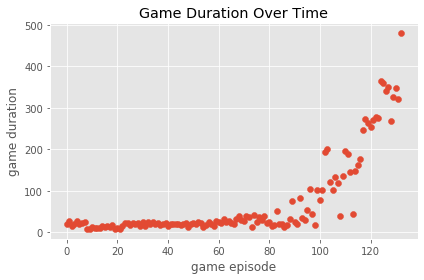

In [4]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.scatter(range(i_episode), game_durations)
plt.title('Game Duration Over Time')
plt.xlabel('game episode')
plt.ylabel('game duration')
plt.tight_layout()